# Impact Assessment

In [ ]:
import bw2data as bd
import pandas as pd
import bw2calc as bc
import numpy as np

bd.projects.set_current("XXX")
bd.databases

Databases dictionary with 17 object(s):
	Activated Carbon
	Catalyst
	Chemicals
	Decomissioning1
	Decomissioning2
	Decomissioning3
	Direct Emissions
	Electricity
	HarmonizationInventories
	Reactor1
	Reactor2
	Reactor3
	Transport OP
	biosphere-3.11
	ecoinvent-3.11-cutoff
	ei11_cut_harmon_35_50
	manual LCIs

In [ ]:
db_list = []
for db in bd.databases:
    db_list.append(db)
print(db_list)

In [ ]:
"""
choose impact method and create list of methods
"""

ia = "ReCiPe 2016 v1.03, midpoint (H) no LT"  # change if needed
ia_category = []
for m in bd.methods:
    try:
        if m[0] == ia:  # looks for exact match of method family name
            # m[0] refers to the first element in the list of tuples - (method family name, impact category, method indicator)
            ia_category.append(m)
    except Exception as e:
        print(f"Error processing method {m}: {e}")

if ia_category:
    print(f"Impact assessment methods with {ia} as method family:")
    for i, method in enumerate(ia_category, start=0):
        print(f"{i}. {method}")
else:
    print(f"No methods found with '{ia}' in the method family name.")
    print("Available method families:")
    # Show first few method families to help debug
    unique_families = set()
    for m in bd.methods:
        try:
            unique_families.add(m[0])
        except:
            pass
    for i, family in enumerate(sorted(unique_families), 1):
        print(f"{i}. {family}")
    print("... (showing first 10)")

Impact assessment methods with ReCiPe 2016 v1.03, midpoint (H) no LT as method family:
0. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT')
1. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
2. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'ecotoxicity: freshwater no LT', 'freshwater ecotoxicity potential (FETP) no LT')
3. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'ecotoxicity: marine no LT', 'marine ecotoxicity potential (METP) no LT')
4. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity potential (TETP) no LT')
5. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'energy resources: non-renewable, fossil no LT', 'fossil fuel potential (FFP) no LT')
6. ('ReCiPe 2016 v1.03, midpoint (H) no LT', 'eutrophication: freshwater no LT', 'freshwater eutrophication potential (FEP) no LT')
7. ('ReCiPe 2016 v1.03, midpoin

## select only the relevant database

In [13]:
# create list of activities
act_list = []

# for all databases in db_list
for db in db_list:
    # add all activities in database
    act_list.extend([act for act in bd.Database(db)])

print(f"Databases contain {len(act_list)} activities")
act_list[:15]  # show only first 10 entries

Databases contain 256 activities


['GAC 223' (cubic meter, RER, None),
 'GAC 139' (cubic meter, RER, None),
 'GAC Regeneration130' (cubic meter, RER, None),
 'GAC Regeneration139' (cubic meter, RER, None),
 'GAC 201' (cubic meter, RER, None),
 'GAC 202' (cubic meter, RER, None),
 'GAC 230' (cubic meter, RER, None),
 'GAC 130' (cubic meter, RER, None),
 'GAC 224' (cubic meter, RER, None),
 'Catalyst 214' (cubic meter, RER, None),
 'Catalyst 106' (cubic meter, RER, None),
 'Catalyst 109' (cubic meter, RER, None),
 'Catalyst 108' (cubic meter, RER, None),
 'Catalyst 105' (cubic meter, RER, None),
 'Catalyst 123' (cubic meter, RER, None)]

In [14]:
# pick a random activity from any non-empty Brightway database and print all metadata
import random

all_db_names = list(bd.databases)
random.shuffle(all_db_names)

chosen_db_name = None
for name in all_db_names:
    if len(bd.Database(name)) > 0:
        chosen_db_name = name
        break

if chosen_db_name is None:
    print("No non-empty databases found in this project.")
else:
    db = bd.Database(chosen_db_name)
    act = random.choice(list(db))
    print(f"Random database: {chosen_db_name}")
    print(f"Random activity: {act['name']} [{act.get('location')}] ({act.get('unit')})")
    # Print full metadata dictionary
    print(dict(act))

Random database: biosphere-3.11
Random activity: Triflumizole [None] (kilogram)
{'categories': ('air', 'non-urban air or from high stacks'), 'code': '7ae72309-b1b3-5a13-9c90-f568c2a54272', 'CAS number': '068694-11-1', 'synonyms': [], 'name': 'Triflumizole', 'database': 'biosphere-3.11', 'unit': 'kilogram', 'type': 'emission', 'id': 241567689378377811}


# Evaluation and Visualization

### Summary for evaluation and csv export

In [15]:
# Summary and joining all cells below in one code
HI_LCIA = pd.DataFrame()


for i in range(len(db_list)):
    first_db_name = db_list[i]  # 0 to 12
    first_db = bd.Database(first_db_name)
    all_acts_fu = {act["code"]: {act.id: 1.0} for act in first_db}
    print(f"Functional units for {first_db_name}: {all_acts_fu}")

    config_1 = {"impact_categories": ia_category}

    print(
        f"Testing LCIA with all activities in database '{first_db_name}': {len(all_acts_fu)} activities"
    )

    try:
        all_acts_data_objs = bd.get_multilca_data_objs(
            functional_units=all_acts_fu, method_config=config_1
        )
        all_acts_mlca = bc.MultiLCA(
            demands=all_acts_fu, method_config=config_1, data_objs=all_acts_data_objs
        )
        all_acts_mlca.lci()
        all_acts_mlca.lcia()
        print("Results for all activities in database generated")
    except Exception as e:
        print(f"Error evaluating all activities in database: {e}")
        exit()

    # create dataframe with results and metadata

    # Build DataFrame from all_acts_mlca.scores
    # keys look like: ((method_family, impact_category, indicator), act_code) -> value
    scores = all_acts_mlca.scores
    print("building HI_df with metadata")
    data_by_act = {}
    for (method_tuple, act_code), value in scores.items():
        _, impact_category, indicator = method_tuple
        col_key = (impact_category, indicator)
        data_by_act.setdefault(act_code, {})[col_key] = value

    HI_df = pd.DataFrame.from_dict(data_by_act, orient="index")

    # Optional: use a MultiIndex for nicer column labeling
    HI_df.columns = pd.MultiIndex.from_tuples(
        HI_df.columns, names=["impact_category", "indicator"]
    )

    # Optional: sort for readability
    HI_df = HI_df.sort_index().sort_index(axis=1)

    # Add activity metadata as columns
    # scores keys: ((method_family, impact_category, indicator), act_code) -> value
    scores = all_acts_mlca.scores

    # Build data dict: act_code -> {col_key: value}
    data_by_act = {}
    for (method_tuple, act_code), value in scores.items():
        _, impact_category, indicator = method_tuple
        col_key = (impact_category, indicator)
        data_by_act.setdefault(act_code, {})[col_key] = value

    print("retrieving metadata from activities")
    # Collect metadata for all act_codes
    metadata_by_act = {}
    for act_code in data_by_act.keys():
        try:
            act = first_db.get(act_code)
            metadata_by_act[act_code] = dict(act)
        except Exception as e:
            print(f"Could not load metadata for {act_code}: {e}")
            metadata_by_act[act_code] = {}

    # Build DataFrame with MultiIndex columns
    # Level 0: 'impact' | 'metadata'
    # Level 1: impact_category | metadata_field
    cols_impact = []
    cols_meta = []
    for act_code in data_by_act:
        for col in data_by_act[act_code]:
            cols_impact.append(("impact", col[0], col[1]))
        for field in metadata_by_act[act_code]:
            cols_meta.append(("metadata", field))

    # Ensure all activities have the same impact columns
    all_impact_cols = sorted(set((ic, ind) for ic, ind in [c[1:] for c in cols_impact]))
    all_meta_cols = sorted(
        set(field for field in metadata_by_act[act_code] for act_code in data_by_act)
    )

    # Build final data dict
    data_final = {}
    for act_code in data_by_act:
        row = {}
        # Impact values
        for ic, ind in all_impact_cols:
            row[("impact", ic, ind)] = data_by_act[act_code].get((ic, ind), np.nan)
        # Metadata values
        for field in all_meta_cols:
            row[("metadata", field)] = metadata_by_act[act_code].get(field, np.nan)
        data_final[act_code] = row

    HI_df = pd.DataFrame.from_dict(data_final, orient="index")
    HI_df.columns = pd.MultiIndex.from_tuples(
        HI_df.columns, names=["category", "field", "indicator"]
    )

    # Optional: sort for readability
    HI_df = HI_df.sort_index().sort_index(axis=1)

    # Optional: show a sample
    print("Data added to HI_df. Shape of HI_df:", HI_df.shape)

    print(f"Adding the new database {first_db_name} to HI_LCIA")
    # add HI_df to a new dataframe
    ### repeat for each database
    # Add HI_df as new rows to HI_LCIA
    if HI_LCIA.empty:
        # If HI_LCIA is empty, just copy HI_df
        HI_LCIA = HI_df.copy()
    else:
        # Concatenate along rows (axis=0) to add new activities
        HI_LCIA = pd.concat([HI_LCIA, HI_df], axis=0, ignore_index=False)

    print(f"HI_LCIA shape: {HI_LCIA.shape}")


# export to csv to check results
HI_LCIA.to_csv(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\HI_LCIA_7_recipe.csv"
)
print("Results exported to csv. Done")

Functional units for Activated Carbon: {'130_gac': {242577492963766276: 1.0}, '139_gac': {242577492963766275: 1.0}, '130_gac_regen': {242577492963766277: 1.0}, '202_gac': {242577492955377664: 1.0}, '201_gac': {242577492951183360: 1.0}, '224_gac': {242577492963766273: 1.0}, '139_gac_regen': {242577492963766278: 1.0}, '223_gac': {242577492963766272: 1.0}, '230_gac': {242577492963766274: 1.0}}
Testing LCIA with all activities in database 'Activated Carbon': 9 activities
Results for all activities in database generated
building HI_df with metadata
retrieving metadata from activities
Data added to HI_df. Shape of HI_df: (9, 32)
Adding the new database Activated Carbon to HI_LCIA
HI_LCIA shape: (9, 32)
Functional units for Catalyst: {'105_cat': {242591339133022208: 1.0}, '107_cat': {242591339149799424: 1.0}, '111_cat': {242591339187548160: 1.0}, '108_cat': {242591339153993728: 1.0}, '109_cat': {242591339170770944: 1.0}, '213_cat': {242591339120439296: 1.0}, '214_cat': {242591339128827904: 1.

### does not work ??

In [ ]:
# define functional units in MultiLCA format: {label: {product_id: amount}}
# demands = {f"inv_{i}": {act.id: 1.0} for i, act in enumerate(act_list)}

# Build a functional unit dictionary mapping each activity to a quantity (e.g., 1.0)
# Example: {bd.Database("ozonation_v1").get("OZ_process_A"): 1, ...}
fu = {}
for db in db_list:
    for act in bd.Database(db):
        # Use activity code as the label and product ID as the key
        fu[act["code"]] = {act.id: 1.0}

config_1 = {"impact_categories": ia_category}
data_objs_1 = bd.get_multilca_data_objs(functional_units=fu, method_config=config_1)

print("Functional units created:", len(fu))
print("First few functional units:", dict(list(fu.items())[:3]))

Functional units created: 257
First few functional units: {'202_gac': {242577492955377664: 1.0}, '230_gac': {242577492963766274: 1.0}, '130_gac': {242577492963766276: 1.0}}


In [ ]:
mlca_1 = bc.MultiLCA(demands=fu, method_config=config_1, data_objs=data_objs_1)
mlca_1.lci()
mlca_1.lcia()
mlca_1.scores

{(('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '130_gac'): 0.0005425210326345077,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '139_gac_regen'): 0.00025695169957417165,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '139_gac'): 0.0008842526176569015,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '130_gac_regen'): 0.00030569364258814546,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '110_cat'): 4.418300132069355e-06,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '105_cat'): 4.418300132069355e-06,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '109_cat'): 4.418300132069355e-06,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '107_cat'): 4.418300132069355e-06,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '106_cat'): 4.418300132069355e-06,
 (('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
  '111_cat'): 4.4183001

### do every DB single and then add to pd dataframe 
is base for summary above

In [60]:
# Evaluate all activities in the first database from db_list
first_db_name = db_list[3]  # 0 to 12
first_db = bd.Database(first_db_name)
all_acts_fu = {act["code"]: {act.id: 1.0} for act in first_db}
print(all_acts_fu)

config_1 = {"impact_categories": ia_category}

print(
    f"Testing with all activities in database '{first_db_name}': {len(all_acts_fu)} activities"
)

try:
    all_acts_data_objs = bd.get_multilca_data_objs(
        functional_units=all_acts_fu, method_config=config_1
    )
    all_acts_mlca = bc.MultiLCA(
        demands=all_acts_fu, method_config=config_1, data_objs=all_acts_data_objs
    )
    all_acts_mlca.lci()
    all_acts_mlca.lcia()
    print("Results for all activities in database:", all_acts_mlca.scores)
except Exception as e:
    print(f"Error evaluating all activities in database: {e}")

{}
Testing with all activities in database 'Decomissioning1': 0 activities
Error evaluating all activities in database: unbound method set.union() needs an argument


In [ ]:
# debuggung f sqlite error

In [ ]:
# create dataframe with results and metadata

# Build DataFrame from all_acts_mlca.scores
# keys look like: ((method_family, impact_category, indicator), act_code) -> value
scores = all_acts_mlca.scores

data_by_act = {}
for (method_tuple, act_code), value in scores.items():
    _, impact_category, indicator = method_tuple
    col_key = (impact_category, indicator)
    data_by_act.setdefault(act_code, {})[col_key] = value

HI_df = pd.DataFrame.from_dict(data_by_act, orient="index")

# Optional: use a MultiIndex for nicer column labeling
HI_df.columns = pd.MultiIndex.from_tuples(
    HI_df.columns, names=["impact_category", "indicator"]
)

# Optional: sort for readability
HI_df = HI_df.sort_index().sort_index(axis=1)

HI_df.head()

impact_category,acidification: terrestrial no LT,climate change no LT,ecotoxicity: freshwater no LT,ecotoxicity: marine no LT,ecotoxicity: terrestrial no LT,"energy resources: non-renewable, fossil no LT",eutrophication: freshwater no LT,eutrophication: marine no LT,human toxicity: carcinogenic no LT,human toxicity: non-carcinogenic no LT,ionising radiation no LT,land use no LT,material resources: metals/minerals no LT,ozone depletion no LT,particulate matter formation no LT,photochemical oxidant formation: human health no LT,photochemical oxidant formation: terrestrial ecosystems no LT,water use no LT
indicator,terrestrial acidification potential (TAP) no LT,global warming potential (GWP100) no LT,freshwater ecotoxicity potential (FETP) no LT,marine ecotoxicity potential (METP) no LT,terrestrial ecotoxicity potential (TETP) no LT,fossil fuel potential (FFP) no LT,freshwater eutrophication potential (FEP) no LT,marine eutrophication potential (MEP) no LT,human toxicity potential (HTPc) no LT,human toxicity potential (HTPnc) no LT,ionising radiation potential (IRP) no LT,agricultural land occupation (LOP) no LT,surplus ore potential (SOP) no LT,ozone depletion potential (ODPinfinite) no LT,particulate matter formation potential (PMFP) no LT,photochemical oxidant formation potential: humans (HOFP) no LT,photochemical oxidant formation potential: ecosystems (EOFP) no LT,water consumption potential (WCP) no LT
130_gac,0.000379,0.073730,0.000008,0.000035,0.039965,0.019695,0.000005,2.380704e-07,0.000097,0.004281,0.000216,0.000733,0.000285,1.198376e-08,0.000127,0.000174,0.000176,0.000096
130_gac_regen,0.000209,0.091827,0.000009,0.000061,0.039638,0.028692,0.000002,9.409508e-07,0.000082,0.002826,0.000092,0.000376,0.000620,1.048177e-08,0.000071,0.000131,0.000138,0.000063
139_gac,0.000614,0.120017,0.000016,0.000063,0.069105,0.042644,0.000012,4.291968e-07,0.000164,0.006944,0.000341,0.001651,0.000551,2.045950e-08,0.000210,0.000296,0.000301,0.000164
139_gac_regen,0.000175,0.077323,0.000007,0.000051,0.033464,0.024171,0.000002,7.931584e-07,0.000069,0.002379,0.000078,0.000317,0.000523,8.825731e-09,0.000060,0.000110,0.000116,0.000053
201_gac,0.020904,3.384050,0.001454,0.005379,5.328271,0.874426,0.000160,1.110400e-05,0.005759,0.361005,0.009466,0.042305,0.018500,6.476242e-07,0.007627,0.008113,0.008270,0.019288


In [ ]:
# Add activity metadata as columns
# scores keys: ((method_family, impact_category, indicator), act_code) -> value
scores = all_acts_mlca.scores

# Build data dict: act_code -> {col_key: value}
data_by_act = {}
for (method_tuple, act_code), value in scores.items():
    _, impact_category, indicator = method_tuple
    col_key = (impact_category, indicator)
    data_by_act.setdefault(act_code, {})[col_key] = value

print(data_by_act)

{'139_gac_regen': {('acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT'): 0.00017539334207256757, ('climate change no LT', 'global warming potential (GWP100) no LT'): 0.07732339611665988, ('ecotoxicity: freshwater no LT', 'freshwater ecotoxicity potential (FETP) no LT'): 7.246867179361076e-06, ('ecotoxicity: marine no LT', 'marine ecotoxicity potential (METP) no LT'): 5.1249371048193476e-05, ('ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity potential (TETP) no LT'): 0.03346384690965663, ('energy resources: non-renewable, fossil no LT', 'fossil fuel potential (FFP) no LT'): 0.024170540221254037, ('eutrophication: freshwater no LT', 'freshwater eutrophication potential (FEP) no LT'): 1.5831759575551857e-06, ('eutrophication: marine no LT', 'marine eutrophication potential (MEP) no LT'): 7.931584345941004e-07, ('human toxicity: carcinogenic no LT', 'human toxicity potential (HTPc) no LT'): 6.896871235730302e-05, ('human toxicity: non-carcinogeni

In [ ]:
print(data_by_act.keys())

dict_keys(['139_gac_regen', '224_gac', '230_gac', '139_gac', '130_gac', '223_gac', '201_gac', '130_gac_regen', '202_gac'])


In [ ]:
# Collect metadata for all act_codes
metadata_by_act = {}
for act_code in data_by_act.keys():
    try:
        act = first_db.get(act_code)
        metadata_by_act[act_code] = dict(act)
    except Exception as e:
        print(f"Could not load metadata for {act_code}: {e}")
        metadata_by_act[act_code] = {}

print(metadata_by_act)

{'139_gac_regen': {'code': '139_gac_regen', 'paper': 'ZeponTarpani2018', 'case_id': 139, 'lcs': 'Operation', 'case_study': 'ZeponTarpani2018-GAC', 'location': 'RER', 'amount': 1000, 'type': 'processwithreferenceproduct', 'unit': 'cubic meter', 'reference product': 'GAC per m3', 'name': 'GAC Regeneration139', 'worksheet name': 'GAC', 'database': 'Activated Carbon', 'id': 242577492963766278}, '224_gac': {'code': '224_gac', 'paper': 'Roth2022', 'case_id': 224, 'lcs': 'Operation', 'case_study': 'Roth2022-UV/H2O2', 'location': 'RER', 'amount': 1, 'type': 'processwithreferenceproduct', 'unit': 'cubic meter', 'reference product': 'GAC per m3', 'name': 'GAC 224', 'worksheet name': 'GAC', 'database': 'Activated Carbon', 'id': 242577492963766273}, '230_gac': {'code': '230_gac', 'paper': 'YangLi2019', 'case_id': 230, 'lcs': 'Operation', 'case_study': 'YangLi2019-GAC', 'location': 'RER', 'amount': 1, 'type': 'processwithreferenceproduct', 'unit': 'cubic meter', 'reference product': 'GAC per m3', '

In [ ]:
import numpy as np

# Build DataFrame with MultiIndex columns
# Level 0: 'impact' | 'metadata'
# Level 1: impact_category | metadata_field
cols_impact = []
cols_meta = []
for act_code in data_by_act:
    for col in data_by_act[act_code]:
        cols_impact.append(("impact", col[0], col[1]))
    for field in metadata_by_act[act_code]:
        cols_meta.append(("metadata", field))

# Ensure all activities have the same impact columns
all_impact_cols = sorted(set((ic, ind) for ic, ind in [c[1:] for c in cols_impact]))
all_meta_cols = sorted(
    set(field for field in metadata_by_act[act_code] for act_code in data_by_act)
)

# Build final data dict
data_final = {}
for act_code in data_by_act:
    row = {}
    # Impact values
    for ic, ind in all_impact_cols:
        row[("impact", ic, ind)] = data_by_act[act_code].get((ic, ind), np.nan)
    # Metadata values
    for field in all_meta_cols:
        row[("metadata", field)] = metadata_by_act[act_code].get(field, np.nan)
    data_final[act_code] = row

HI_df = pd.DataFrame.from_dict(data_final, orient="index")
HI_df.columns = pd.MultiIndex.from_tuples(
    HI_df.columns, names=["category", "field", "indicator"]
)

# Optional: sort for readability
HI_df = HI_df.sort_index().sort_index(axis=1)

# Optional: show a sample
print("Shape:", HI_df.shape)
print("Columns (first 10):", HI_df.columns.tolist()[:10])
print("Sample (first 2 rows, first 2 cols):")
print(HI_df.iloc[:2, :2])

Shape: (9, 32)
Columns (first 10): 

[('impact', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT'), ('impact', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('impact', 'ecotoxicity: freshwater no LT', 'freshwater ecotoxicity potential (FETP) no LT'), ('impact', 'ecotoxicity: marine no LT', 'marine ecotoxicity potential (METP) no LT'), ('impact', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity potential (TETP) no LT'), ('impact', 'energy resources: non-renewable, fossil no LT', 'fossil fuel potential (FFP) no LT'), ('impact', 'eutrophication: freshwater no LT', 'freshwater eutrophication potential (FEP) no LT'), ('impact', 'eutrophication: marine no LT', 'marine eutrophication potential (MEP) no LT'), ('impact', 'human toxicity: carcinogenic no LT', 'human toxicity potential (HTPc) no LT'), ('impact', 'human toxicity: non-carcinogenic no LT', 'human toxicity potential (HTPnc) no LT')]
Sample (first 2 rows, first 2 cols):
category                         

repeat for each database

In [ ]:
# add HI_df to a new dataframe
### repeat for each database
# Add HI_df as new rows to HI_LCIA
if HI_LCIA.empty:
    # If HI_LCIA is empty, just copy HI_df
    HI_LCIA = HI_df.copy()
else:
    # Concatenate along rows (axis=0) to add new activities
    HI_LCIA = pd.concat([HI_LCIA, HI_df], axis=0, ignore_index=False)

print(f"HI_LCIA shape: {HI_LCIA.shape}")
print("Index (activities):", HI_LCIA.index.tolist()[:10])
print("Columns:", HI_LCIA.columns.tolist()[:10])

HI_LCIA shape: (9, 32)
Index (activities): ['130_gac', '130_gac_regen', '139_gac', '139_gac_regen', '201_gac', '202_gac', '223_gac', '224_gac', '230_gac']
Columns: [('impact', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT'), ('impact', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('impact', 'ecotoxicity: freshwater no LT', 'freshwater ecotoxicity potential (FETP) no LT'), ('impact', 'ecotoxicity: marine no LT', 'marine ecotoxicity potential (METP) no LT'), ('impact', 'ecotoxicity: terrestrial no LT', 'terrestrial ecotoxicity potential (TETP) no LT'), ('impact', 'energy resources: non-renewable, fossil no LT', 'fossil fuel potential (FFP) no LT'), ('impact', 'eutrophication: freshwater no LT', 'freshwater eutrophication potential (FEP) no LT'), ('impact', 'eutrophication: marine no LT', 'marine eutrophication potential (MEP) no LT'), ('impact', 'human toxicity: carcinogenic no LT', 'human toxicity potential (HTPc) no LT'), ('

skip

In [ ]:
# export to csv to check results
HI_df.to_csv(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\HI_react1.csv"
)

In [ ]:
HI_LCIA = pd.DataFrame()

In [69]:
# export to csv to check results
HI_LCIA.to_csv(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\HI_LCIA_5_recipe.csv"
)

### DeBUG

In [ ]:
# test with single activity
# Debug: Test with just one activity to isolate the issue
test_fu = {"test_act": {list(bd.Database(db_list[0]))[0].id: 1.0}}
print("Testing with single activity:", test_fu)

try:
    test_data_objs = bd.get_multilca_data_objs(
        functional_units=test_fu, method_config=config_1
    )
    test_mlca = bc.MultiLCA(
        demands=test_fu, method_config=config_1, data_objs=test_data_objs
    )
    test_mlca.lci()
    test_mlca.lcia()
    print("Single activity result:", test_mlca.scores)
except Exception as e:
    print(f"Error with single activity: {e}")

In [ ]:
# test with less activities
# Try with just a subset of activities to see if it works
print("Trying with subset of activities...")

# Take only first 10 activities from each database
limited_fu = {}
for db_name in db_list[:3]:  # Only first 3 databases
    count = 0
    for act in bd.Database(db_name):
        if count >= 10:  # Only 10 activities per database
            break
        limited_fu[act["code"]] = {act.id: 1.0}
        count += 1

print(f"Created functional units for {len(limited_fu)} activities")

try:
    limited_data_objs = bd.get_multilca_data_objs(
        functional_units=limited_fu, method_config=config_1
    )
    limited_mlca = bc.MultiLCA(
        demands=limited_fu, method_config=config_1, data_objs=limited_data_objs
    )
    limited_mlca.lci()
    limited_mlca.lcia()

    nan_count = sum(1 for v in limited_mlca.scores.values() if str(v) == "nan")
    print(
        f"Limited calculation: {len(limited_mlca.scores) - nan_count}/{len(limited_mlca.scores)} successful"
    )

except Exception as e:
    print(f"Error with limited calculation: {e}")

In [ ]:
# Debug: Check what's actually happening with the data
print("Deep debugging of the calculation...")

# 1. Check if your activities are properly connected to the technosphere
print("1. Checking technosphere connectivity...")
sample_act = list(bd.Database(db_list[0]))[0]
print(f"Sample activity: {sample_act['name']} (ID: {sample_act.id})")

# Check if this activity can be found in the technosphere
try:
    # Try to find this activity in the technosphere
    from bw2data import get_node

    node = get_node(sample_act.id)
    print(f"Activity found in technosphere: {node}")
except Exception as e:
    print(f"Activity NOT found in technosphere: {e}")

# 2. Check if the technosphere matrix is properly built
print("\n2. Checking technosphere matrix...")
try:
    # Try to build a small technosphere matrix
    from bw2calc import LCA

    test_demand = {sample_act.id: 1.0}
    test_method = ia_category[0]  # Use first method

    lca = LCA(test_demand, test_method)
    lca.lci()
    print(f"Single LCA successful: {lca.score}")
except Exception as e:
    print(f"Single LCA failed: {e}")

# 3. Check if your databases are properly registered
print("\n3. Checking database registration...")
for db_name in db_list:
    db = bd.Database(db_name)
    print(f"Database '{db_name}': {len(db)} activities")
    print(f"  Registered: {db_name in bd.databases}")
    print(f"  Has technosphere: {hasattr(db, 'technosphere_matrix')}")

Debug Chemicals database

In [ ]:
db = bd.Database("Chemicals")

problems = []
for act in db:
    ok, why = act.valid(why=True)
    if not ok:
        problems.append(("activity", act.get("code"), why))

    # Drill down into exchanges too
    for exc in act.exchanges():
        ok_e, why_e = exc.valid(why=True)
        if not ok_e:
            problems.append(("exchange", act.get("code"), why_e))

print(f"Found {len(problems)} issues")
for kind, code, why in problems[:20]:  # preview first 20
    print(kind, code, "->", why)

In [ ]:
# Check if the database is properly registered
print("Available databases:", list(bd.databases))
print("Chemical in databases:", "Chemical" in bd.databases)

# Check database status
chem_db = bd.Database("Chemical")
print(f"Chemical database: {len(chem_db)} activities")
print(f"Database registered: {chem_db.registered}")

In [ ]:
# register and then delete
chem = bd.Database("Chemicals")
if not chem.registered:
    chem.register(write_empty=False)  # adds registry entry without touching rows
chem.delete()  # removes registry entry and all rows for this database
print("Chemicals in databases:", "Chemicals" in bd.databases)
print("Rows remaining:", len(bd.Database("Chemicals")))

In [ ]:
# checking each activity in db

# Test each activity individually to find the corrupted ones
first_db_name = db_list[2]  # 'Chemical'
first_db = bd.Database(first_db_name)

print(f"Testing each activity in '{first_db_name}' individually...")

problematic_activities = []
working_activities = []

for i, act in enumerate(first_db):
    act_code = act["code"]
    print(f"Testing {i+1}/{len(first_db)}: {act_code}")

    try:
        # Test with single activity
        test_fu = {act_code: {act.id: 1.0}}

        # Test data objects creation
        test_data_objs = bd.get_multilca_data_objs(
            functional_units=test_fu, method_config=config_1
        )

        # Test MultiLCA creation
        test_mlca = bc.MultiLCA(
            demands=test_fu, method_config=config_1, data_objs=test_data_objs
        )

        # Test LCI calculation
        test_mlca.lci()

        # Test LCIA calculation
        test_mlca.lcia()

        # Check for nan values
        nan_count = sum(1 for v in test_mlca.scores.values() if str(v) == "nan")
        if nan_count > 0:
            problematic_activities.append(
                (act_code, f"Produced {nan_count} nan values")
            )
        else:
            working_activities.append(act_code)

    except Exception as e:
        problematic_activities.append((act_code, str(e)))
        print(f"  ERROR: {e}")

print(f"\nSUMMARY:")
print(f"Working activities: {len(working_activities)}")
print(f"Problematic activities: {len(problematic_activities)}")

if working_activities:
    print(f"\nFirst 5 working: {working_activities[:5]}")

if problematic_activities:
    print(f"\nProblematic activities:")
    for act_code, error in problematic_activities[:10]:  # Show first 10
        print(f"  {act_code}: {error}")

In [ ]:
# Check for database name mismatches
print("Checking database name consistency...")

# Check what database name is actually stored in activities
db_names_in_activities = set()
for act in first_db:
    db_names_in_activities.add(act.get("database", "None"))

print(f"Database names found in activities: {db_names_in_activities}")

# Check if there's a mismatch
if db_names_in_activities != {first_db_name}:
    print(f"WARNING: Database name mismatch!")
    print(f"Expected: {first_db_name}")
    print(f"Found: {db_names_in_activities}")

    # Fix the database names
    print("Fixing database names...")
    for act in first_db:
        if act.get("database") != first_db_name:
            act["database"] = first_db_name
    print("Database names fixed!")

In [ ]:
# Check what the actual database name should be
print("Checking actual database names...")
print(f"db_list[2] = '{db_list[2]}'")
print(f"Available databases: {[db for db in bd.databases if 'chem' in db.lower()]}")

# Maybe it should be 'Chemical' (singular) instead of 'Chemicals' (plural)?
if "Chemical" in bd.databases:
    print("Found 'Chemical' in databases - using that instead")
    first_db_name = "Chemical"
    first_db = bd.Database(first_db_name)

## From BW25 notebook

In [ ]:
# Find methods
ef_methods = list(filter(lambda x: "EF v3.0" in x[1], list(bd.methods)))
print("We have", len(ef_methods), "methods we will evaluate.")

print(ef_methods)

In [ ]:
# check all activities
for db in db_list:
    for act in bd.Database(db):
        print(act["name"])

In [ ]:
functional_units_1 = {
    "act1": {wb.get("act1").id: 1},
}
config_1 = {"impact_categories": ef_methods}
data_objs_1 = bd.get_multilca_data_objs(
    functional_units=functional_units_1, method_config=config_1
)

# Explore and play with results
Visualize completeness

In [51]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [115]:
## From BW25 notebook
path = r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\HI_LCIA_7_recipe.csv"
lcia = pd.read_csv(path)

lcia.head()

,category,impact,impact.1,impact.2,impact.3,impact.4,impact.5,impact.6,impact.7,impact.8,...,metadata.4,metadata.5,metadata.6,metadata.7,metadata.8,metadata.9,metadata.10,metadata.11,metadata.12,metadata.13
0,field,acidification: terrestrial no LT,climate change no LT,ecotoxicity: freshwater no LT,ecotoxicity: marine no LT,ecotoxicity: terrestrial no LT,"energy resources: non-renewable, fossil no LT",eutrophication: freshwater no LT,eutrophication: marine no LT,human toxicity: carcinogenic no LT,...,database,id,lcs,location,name,paper,reference product,type,unit,worksheet name
1,indicator,terrestrial acidification potential (TAP) no LT,global warming potential (GWP100) no LT,freshwater ecotoxicity potential (FETP) no LT,marine ecotoxicity potential (METP) no LT,terrestrial ecotoxicity potential (TETP) no LT,fossil fuel potential (FFP) no LT,freshwater eutrophication potential (FEP) no LT,marine eutrophication potential (MEP) no LT,human toxicity potential (HTPc) no LT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,130_gac,0.0003785611967697653,0.0737304007261036,7.84578650115938e-06,3.488092120675109e-05,0.03996460944042193,0.019695141707850323,5.17864019140353e-06,2.3807041337556623e-07,9.72478596322709e-05,...,Activated Carbon,242577492963766276,Operation,RER,GAC 130,Rahman2018,GAC per m3,processwithreferenceproduct,cubic meter,GAC
3,130_gac_regen,0.00020868020762729019,0.09182689638256697,8.600832484727589e-06,6.076835691221388e-05,0.03963820819884538,0.028691889103398642,1.8842049712917849e-06,9.409508397679418e-07,8.191274753473249e-05,...,Activated Carbon,242577492963766277,Operation,RER,GAC Regeneration130,Rahman2018,GAC per m3,processwithreferenceproduct,cubic meter,GAC
4,139_gac,0.0006141107922090507,0.12001703454503217,1.605315461858826e-05,6.344818278925435e-05,0.0691051420274831,0.042644212903448254,1.2060763368578022e-05,4.2919682867817565e-07,0.00016365253132548185,...,Activated Carbon,242577492963766275,Operation,RER,GAC 139,ZeponTarpani2018,GAC per m3,processwithreferenceproduct,cubic meter,GAC


### Visualize Completeness
1. Create New Dataframe with column headings

In [116]:
# Visualize inventory

# tuple with metadata.1
m1 = list(lcia["metadata.1"].unique())
m2 = list(lcia["metadata.2"].unique())
print(m1)
print(m2)

['case_id', nan, '130', '139', '201', '202', '223', '224', '230', '105', '106', '107', '108', '109', '110', '111', '123', '213', '214', '101', '102', '103', '112', '114', '115', '116', '117', '118', '120', '125', '126', '127', '128', '129', '133', '135', '136', '137', '138', '140', '141', '142', '203', '204', '205', '207', '208', '209', '211', '212', '216', '217', '218', '219', '220', '221', '229', '231', '121', '122', '131', '132', '134', '226', '227', '124']
['case_study', nan, 'Rahman2018-GAC', 'ZeponTarpani2018-GAC', 'Choudhary2022-GAC', 'Choudhary2022-BAC', 'Roth2022-LPRO', 'Roth2022-UV/H2O2', 'YangLi2019-GAC', 'Conde2023-F3', 'Conde2023-PF3', 'Conde2023-EF3', 'Conde2023-PEF3', 'Conde2023-PF7', 'Conde2023-EF7', 'Conde2023-PEF7', 'Notarnicola2023-UV/TiO2', 'Pesqueira2024-SPF+P25', 'Pesqueira2024-SPF+GO-TiO2', 'Amaya-Santos2025-OZ', 'Arzate2019-OZ', 'Arzate2019-PF3+SF', 'Igos2012-OZ', 'Gallego-Schmid2019-SPF3', 'Gallego-Schmid2019-SPF3+NF', 'Gallego-Schmid2019-SPF7', 'Gallego-Schmid

In [117]:
print(f"Type of m1: {type(m1)} with length {len(m1)}")
print(f"Type of m2: {type(m2)} with length {len(m1)}")

Type of m1: <class 'list'> with length 66
Type of m2: <class 'list'> with length 66


In [127]:
# Create new dataframe with content of lcia df field metadata.1 and metadata.2 as first columns
# Convert lists to pandas Series to handle nan values properly
m1_series = pd.Series(m1)
m2_series = pd.Series(m2)

completeness = pd.DataFrame({"metadata.1": m1_series, "metadata.2": m2_series})

completeness.head()

,metadata.1,metadata.2
0,case_id,case_study
1,NaN,NaN
2,130,Rahman2018-GAC
3,139,ZeponTarpani2018-GAC
4,201,Choudhary2022-GAC


In [128]:
# create unique list of Databases
list_db = list(lcia["metadata.4"].unique())

# add as column headers in completeness df
# Add new columns with names from your list
# Create a dictionary from your list and assign
new_cols = pd.DataFrame(columns=list_db)
completeness = pd.concat([completeness, new_cols], axis=1)

completeness.head()

# TRUE/FALSE Column

,metadata.1,metadata.2,database,NaN,Activated Carbon,Catalyst,Chemicals,Decomissioning1,Decomissioning2,Decomissioning3,Direct Emissions,Electricity,Reactor1,Reactor2,Reactor3,Transport OP
0,case_id,case_study,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,130,Rahman2018-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,139,ZeponTarpani2018-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201,Choudhary2022-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Drop by position (0-indexed columnes and rows)
completeness = completeness.drop(completeness.columns[[2, 3]], axis=1)
completeness = completeness.drop(completeness.index[[1, 0]])
completeness.head()

,metadata.1,metadata.2,Activated Carbon,Catalyst,Chemicals,Decomissioning1,Decomissioning2,Decomissioning3,Direct Emissions,Electricity,Reactor1,Reactor2,Reactor3,Transport OP
2,130,Rahman2018-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,139,ZeponTarpani2018-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201,Choudhary2022-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,202,Choudhary2022-BAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,223,Roth2022-LPRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
print(completeness.columns.tolist())

['metadata.1', 'metadata.2', 'Activated Carbon', 'Catalyst', 'Chemicals', 'Decomissioning1', 'Decomissioning2', 'Decomissioning3', 'Direct Emissions', 'Electricity', 'Reactor1', 'Reactor2', 'Reactor3', 'Transport OP']


In [131]:
sort_col = [
    "metadata.1",
    "metadata.2",
    "Reactor1",
    "Reactor2",
    "Reactor3",
    "Electricity",
    "Chemicals",
    "Catalyst",
    "Activated Carbon",
    "Transport OP",
    "Direct Emissions",
    "Decomissioning1",
    "Decomissioning2",
    "Decomissioning3",
]

completeness = completeness[sort_col]
completeness.head()

,metadata.1,metadata.2,Reactor1,Reactor2,Reactor3,Electricity,Chemicals,Catalyst,Activated Carbon,Transport OP,Direct Emissions,Decomissioning1,Decomissioning2,Decomissioning3
2,130,Rahman2018-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,139,ZeponTarpani2018-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201,Choudhary2022-GAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,202,Choudhary2022-BAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,223,Roth2022-LPRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
completeness.shape

(64, 14)

### Visualize Completeness
2. Add Data

In [135]:
path = r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\missing_data.xlsx"
missing_data = pd.read_excel(path)

missing_data.shape

(182, 4)

In [136]:
# add data from lcia to completeness
for col in completeness.columns:
    if col not in ["metadata.1", "metadata.2"]:
        completeness[col] = (
            completeness["metadata.1"]
            .apply(
                lambda x: (
                    (lcia["metadata.1"] == x) & (lcia["metadata.4"] == col)
                ).any()
            )
            .astype(int)
        )

# if case ID is in missing_data, add it with 2 to the completeness df in the respective column with name from missing_data["LCS database"]
for idx, row in missing_data.iterrows():
    case_id = row["UUID"]
    if case_id in completeness["metadata.2"].values:
        col_name = row["LCS database"]
        if col_name in completeness.columns:
            completeness.loc[completeness["metadata.2"] == case_id, col_name] += 2

completeness.head()

,metadata.1,metadata.2,Reactor1,Reactor2,Reactor3,Electricity,Chemicals,Catalyst,Activated Carbon,Transport OP,Direct Emissions,Decomissioning1,Decomissioning2,Decomissioning3
2,130,Rahman2018-GAC,1,0,0,1,0,0,1,0,0,2,0,0
3,139,ZeponTarpani2018-GAC,1,0,0,1,1,0,1,0,1,1,0,0
4,201,Choudhary2022-GAC,2,0,0,3,0,0,3,1,1,0,0,0
5,202,Choudhary2022-BAC,2,0,0,3,0,0,1,1,1,0,0,0
6,223,Roth2022-LPRO,1,1,1,1,1,0,3,0,0,1,1,2


In [137]:
completeness.tail()

,metadata.1,metadata.2,Reactor1,Reactor2,Reactor3,Electricity,Chemicals,Catalyst,Activated Carbon,Transport OP,Direct Emissions,Decomissioning1,Decomissioning2,Decomissioning3
61,132,Rahman2018-UV/H2O2,3,0,0,1,0,0,0,0,2,0,0,0
62,134,Surra2024-NTP,2,0,0,1,0,0,0,0,2,2,0,0
63,226,Surra2021-BDD,3,3,0,1,0,0,0,0,0,2,2,0
64,227,Surra2021-MMO,3,3,0,1,0,0,0,0,0,2,2,0
65,124,Pesqueira2021-Solar,1,0,0,2,0,0,0,0,2,2,0,0


In [ ]:
# Your 3 lists of column names
upstream = ["Reactor1", "Reactor2", "Reactor3"]
operation = [
    "Electricity",
    "Chemicals",
    "Catalyst",
    "Activated Carbon",
    "Transport OP",
    "Direct Emissions",
]
downstream = [
    "Decomissioning1",
    "Decomissioning2",
    "Decomissioning3",
]

C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\1697390021.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_for_plot = df_for_plot.fillna(0).astype(int)


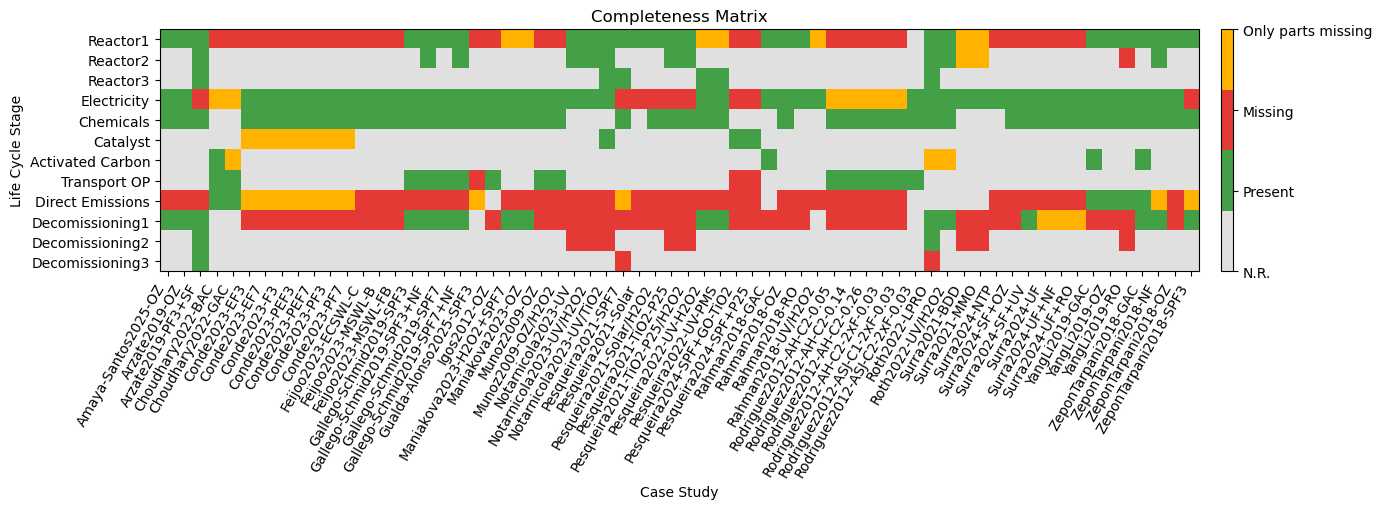

In [ ]:
### PLOT COMPLETENESS
import matplotlib.pyplot as plt


import numpy as np


from matplotlib.colors import ListedColormap


# Custom colormap: 0 = gray, 1 = green, 2 = red, 3 = orange


colors = [
    "#E0E0E0",  # 0: n.r. (modern light gray)
    "#43A047",  # 1: present (modern green)
    "#E53935",  # 2: missing and marked as explicitly missing (modern red)
    "#FFB300",  # 3: only parts are missing (modern amber/orange)
]
cmap = ListedColormap(colors)


# Prepare the dataframe for plotting:
# Switch so that cases are columns (x) and components/stages are rows (y)
value_columns = [
    c for c in completeness.columns if c not in ["metadata.1", "metadata.2"]
]
# Build cases list and collect row data directly (simpler - no need for index pairs)
case_data_pairs = [
    (str(row["metadata.2"]), row[value_columns].values)
    for _, row in completeness.iterrows()
]

# Sort by case name alphabetically
case_data_pairs_sorted = sorted(case_data_pairs, key=lambda x: x[0])
cases_sorted = [case for case, _ in case_data_pairs_sorted]
data_sorted = [data for _, data in case_data_pairs_sorted]

# Build a new DataFrame
df_for_plot = pd.DataFrame(
    {case: data for case, data in zip(cases_sorted, data_sorted)},
    index=value_columns,
)  # Transpose once: rows = value_columns, cols = cases_sorted

# Ensure integer type for correct color mapping
df_for_plot = df_for_plot.fillna(0).astype(int)

# Plot
fig_width = max(6, int(0.22 * len(cases_sorted)))  # Use cases_sorted
fig_height = 1 + len(value_columns) * 0.35
plt.figure(figsize=(fig_width, fig_height))
im = plt.imshow(
    df_for_plot.values, cmap=cmap, aspect="auto", vmin=0, vmax=len(colors) - 1
)

plt.xticks(
    range(len(cases_sorted)), cases_sorted, rotation=60, ha="right"
)  # Use cases_sorted
plt.yticks(range(len(value_columns)), value_columns)
plt.xlabel("Case Study")
plt.ylabel("Life Cycle Stage")

plt.title("Completeness Matrix")

# Colorbar with custom ticks/labels if you want to explain the color scale:
cbar = plt.colorbar(
    im, orientation="vertical", fraction=0.025, pad=0.02, ticks=[0, 1, 2, 3]
)
cbar.ax.set_yticklabels(["N.R.", "Present", "Missing", "Only parts missing"])

plt.tight_layout()


plt.show()

# Results per Impact Category

In [144]:
# FIXED VERSION: Aggregate the first impact category
# This version ensures numeric conversion BEFORE pivoting to prevent string concatenation

# IMPORTANT: Convert impact column to numeric BEFORE pivoting
# Create a copy of the dataframe with numeric conversion
lcia_numeric = lcia.copy()
lcia_numeric["impact.1"] = pd.to_numeric(
    lcia_numeric["impact.1"], errors="coerce"
).fillna(0)

# Now create the pivot table - values will be properly summed as numbers
gwp_fossil = lcia_numeric.pivot_table(
    index="metadata.1",  # case_id as rows
    columns="metadata.4",  # database as columns
    values="impact.1",  # second impact category (now numeric)
    aggfunc="sum",  # or 'mean', 'count', etc.
    fill_value=0,  # fill missing values with 0
)

# Ensure all values are numeric (defensive check)
gwp_fossil = gwp_fossil.apply(pd.to_numeric, errors="coerce").fillna(0)

gwp_fossil.iloc[10:20].reset_index().head(11)

metadata.4,metadata.1,Activated Carbon,Catalyst,Chemicals,Decomissioning1,Decomissioning2,Decomissioning3,Direct Emissions,Electricity,Reactor1,Reactor2,Reactor3,Transport OP,database
0,112,0.0,0.000000,0.023982,0.000000e+00,0.0,0.0,0.0,0.020058,0.000000,0.00000,0.000000,0.000972,0.0
1,114,0.0,0.000000,0.197571,2.240411e-06,0.0,0.0,0.0,0.093605,0.000020,0.00000,0.000000,0.027989,0.0
2,115,0.0,0.000000,0.056795,6.019251e-07,0.0,0.0,0.0,0.117006,0.000005,0.00164,0.000000,0.008650,0.0
3,116,0.0,0.000000,0.551594,1.989196e-06,0.0,0.0,0.0,0.093605,0.000018,0.00000,0.000000,0.023383,0.0
4,117,0.0,0.000000,0.267939,7.695487e-07,0.0,0.0,0.0,0.117006,0.000003,0.00164,0.000000,0.013431,0.0
5,118,0.0,0.000000,0.077508,0.000000e+00,0.0,0.0,0.0,0.090262,0.000000,0.00000,0.000000,0.002721,0.0
6,120,0.0,0.000000,0.097093,0.000000e+00,0.0,0.0,0.0,0.090262,0.000000,0.00000,0.000000,0.003304,0.0
7,121,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,25.975358,0.005155,0.00261,0.000000,0.000000,0.0
8,122,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,6.485482,0.001289,0.00261,0.000000,0.000000,0.0
9,123,0.0,0.077838,0.000000,0.000000e+00,0.0,0.0,0.0,18.186095,0.003609,0.00261,0.000489,0.000000,0.0


In [29]:
print(upstream)
print(operation)
print(downstream)

['Reactor1', 'Reactor2', 'Reactor3']
['Electricity', 'Chemicals', 'Catalyst', 'Activated Carbon', 'Transport OP', 'Direct Emissions']
['Decomissioning1', 'Decomissioning2', 'Decomissioning3']


In [145]:
# Optionally clean separators/whitespace first
# gwp_fossil = gwp_fossil.replace({r'[,\s]': ''}, regex=True)

# Coerce to numeric; non-numeric becomes NaN
gwp_fossil = gwp_fossil.apply(pd.to_numeric, errors="coerce")

# Now safe to sum across columns
gwp_fossil["Upstream"] = gwp_fossil[upstream].sum(axis=1, skipna=True)
gwp_fossil["Operation"] = (
    gwp_fossil[operation].apply(pd.to_numeric, errors="coerce").sum(axis=1, skipna=True)
)
gwp_fossil["Downstream"] = (
    gwp_fossil[downstream]
    .apply(pd.to_numeric, errors="coerce")
    .sum(axis=1, skipna=True)
)

gwp_fossil.iloc[10:20].reset_index().head(11)

metadata.4,metadata.1,Activated Carbon,Catalyst,Chemicals,Decomissioning1,Decomissioning2,Decomissioning3,Direct Emissions,Electricity,Reactor1,Reactor2,Reactor3,Transport OP,database,Upstream,Operation,Downstream
0,112,0.0,0.000000,0.023982,0.000000e+00,0.0,0.0,0.0,0.020058,0.000000,0.00000,0.000000,0.000972,0.0,0.000000,0.045012,0.000000e+00
1,114,0.0,0.000000,0.197571,2.240411e-06,0.0,0.0,0.0,0.093605,0.000020,0.00000,0.000000,0.027989,0.0,0.000020,0.319165,2.240411e-06
2,115,0.0,0.000000,0.056795,6.019251e-07,0.0,0.0,0.0,0.117006,0.000005,0.00164,0.000000,0.008650,0.0,0.001645,0.182451,6.019251e-07
3,116,0.0,0.000000,0.551594,1.989196e-06,0.0,0.0,0.0,0.093605,0.000018,0.00000,0.000000,0.023383,0.0,0.000018,0.668581,1.989196e-06
4,117,0.0,0.000000,0.267939,7.695487e-07,0.0,0.0,0.0,0.117006,0.000003,0.00164,0.000000,0.013431,0.0,0.001642,0.398376,7.695487e-07
5,118,0.0,0.000000,0.077508,0.000000e+00,0.0,0.0,0.0,0.090262,0.000000,0.00000,0.000000,0.002721,0.0,0.000000,0.170492,0.000000e+00
6,120,0.0,0.000000,0.097093,0.000000e+00,0.0,0.0,0.0,0.090262,0.000000,0.00000,0.000000,0.003304,0.0,0.000000,0.190659,0.000000e+00
7,121,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,25.975358,0.005155,0.00261,0.000000,0.000000,0.0,0.007765,25.975358,0.000000e+00
8,122,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,6.485482,0.001289,0.00261,0.000000,0.000000,0.0,0.003899,6.485482,0.000000e+00
9,123,0.0,0.077838,0.000000,0.000000e+00,0.0,0.0,0.0,18.186095,0.003609,0.00261,0.000489,0.000000,0.0,0.006708,18.263933,0.000000e+00


In [31]:
# gwp_fossil['Upstream'] = gwp_fossil[upstream].sum(axis=1)
# gwp_fossil['Operation'] = gwp_fossil[operation].sum(axis=1)
# gwp_fossil['Downstream'] = gwp_fossil[downstream].sum(axis=1)
gwp_fossil["Total"] = gwp_fossil[["Upstream", "Operation", "Downstream"]].sum(axis=1)

In [32]:
path = r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\gwp_total07_recipe.xlsx"

gwp_fossil.to_excel(path)

# Visualize per techology and scale
e.g. all Ozonation in same color // Pilot / Industrial Scale in other formats

In [146]:
# add info for scale and technology --> import excel
tech_scale = pd.read_excel(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\CS_metadata.xlsx"
)

gwp_fossil = pd.read_excel(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\gwp_total07_recipe.xlsx",
    sheet_name="Sheet1",
)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Asus\\OneDrive - Universidade de Santiago de Compostela\\07_Papers\\Harmonization study\\gwp_total07_recipe.xlsx'

In [5]:
# Merge gwp_fossil and tech_scale on the case study ID
# Assuming 'metadata.1' in gwp_fossil matches 'case study ID' in tech_scale

# If 'metadata.1' is the index, reset it first
if gwp_fossil.index.name == "metadata.1":
    gwp_fossil_reset = gwp_fossil.reset_index()
else:
    gwp_fossil_reset = gwp_fossil

# Merge the two dataframes
# Ensure both columns used for merging are of the same type (string)
gwp_fossil_reset["metadata.1"] = gwp_fossil_reset["metadata.1"].astype(str)
tech_scale["case study ID"] = tech_scale["case study ID"].astype(str)

gwp_agg = pd.merge(
    gwp_fossil_reset,
    tech_scale,
    left_on="metadata.1",
    right_on="case study ID",
    how="left",
)

gwp_agg.head()

,metadata.1,Activated Carbon,Catalyst,Chemicals,Decomissioning1,Decomissioning2,Decomissioning3,Direct Emissions,Electricity,Reactor1,...,CBZ end [µg/l],include?,Scenario Name,UUID,Reactor 1,case study ID,Tech_group,GWP/m3,Impact method,Database
0,101,0.0,0.000000,0.055219,0.000109,0.000000,0.000000,0.000000,0.097224,0.000523,...,0.195,y,OZ,Amaya-Santos2025-OZ,Ozonation,101,Ozonation,0.140,Environmental Footprint 3.0,Ecoinvent ??
1,102,0.0,0.000000,0.054679,0.003422,0.000000,0.000000,0.000000,0.056832,0.055949,...,0.001,y,OZ,Arzate2019-OZ,Ozonation,102,Ozonation,0.235,"ReCiPe 2016 midpoint (H) v1.13 ,USEtox V1.04,U...",Ecoinvent 3.3
2,103,0.0,0.000000,0.678751,0.002980,0.000186,0.000314,0.000000,0.000000,0.083412,...,0.023,y,PF3+SF,Arzate2019-PF3+SF,CPC,103,homogenous Fenton pH3,0.864,"ReCiPe 2016 midpoint (H) v1.13 ,USEtox V1.04,U...",Ecoinvent 3.3
3,105,0.0,0.001758,2.447830,0.000000,0.000000,0.000000,0.003670,3.213657,0.000000,...,75.000,y,F3,Conde2023-F3,Fenton,105,heterogenous Fenton pH3,6.350,ReCiPe 2016 midpoint (H),Ecoinvent 3.8
4,106,0.0,0.001758,2.447830,0.000000,0.000000,0.000000,0.003726,0.729450,0.000000,...,75.000,y,PF3,Conde2023-PF3,Photo Fenton,106,heterogenous Fenton pH3,3.730,ReCiPe 2016 midpoint (H),Ecoinvent 3.8


In [6]:
gwp_agg = gwp_agg.iloc[:-1]  # to get rid of case_id row in the end
gwp_agg.tail()

,metadata.1,Activated Carbon,Catalyst,Chemicals,Decomissioning1,Decomissioning2,Decomissioning3,Direct Emissions,Electricity,Reactor1,...,CBZ end [µg/l],include?,Scenario Name,UUID,Reactor 1,case study ID,Tech_group,GWP/m3,Impact method,Database
59,226,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.174909,0.075237,...,NaN,NaN,BDD,Surra2021-BDD,BDD electrode,226,electrochemical Oxidation,NaN,"ReCiPe 2016 Endpoint (H) v1.13,USEtox",Ecoinvent 3.5
60,227,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.174909,0.075237,...,NaN,NaN,MMO,Surra2021-MMO,MMO electrode,227,electrochemical Oxidation,NaN,"ReCiPe 2016 Endpoint (H) v1.13,USEtox",Ecoinvent 3.5
61,229,0.000000,0.0,0.031039,0.0,0.0,0.0,0.007399,0.193562,0.001657,...,0.02259,NaN,OZ,YangLi2019-OZ,Ozonation reactor,229,Ozonation,NaN,"USEtox,TRACI 2.1",???
62,230,0.049832,0.0,0.323618,0.0,0.0,0.0,0.006723,0.077224,0.001658,...,0.07530,NaN,GAC,YangLi2019-GAC,2 Column GAC,230,Activated Carbon,NaN,"USEtox,TRACI 2.1",???
63,231,0.000000,0.0,0.224013,0.0,0.0,0.0,0.010321,0.397821,0.001657,...,0.01506,NaN,RO,YangLi2019-RO,Microfiltration,231,Reverse Osmosis,NaN,"USEtox,TRACI 2.1",???


In [ ]:
# show row with Tech_Group = electrochemical Oxidation
eaop = gwp_agg[gwp_agg["Tech_group"] == "electrochemical Oxidation"]
eaop.head()

# show column primary data and UUID
eaop[["primary data", "UUID"]]

,primary data,UUID
41,Bench Scale,Feijoo2023-ECSWL-C
42,Bench Scale,Feijoo2023-MSWL-B
43,Bench Scale,Feijoo2023-MSWL-FB
59,Pilot Scale,Surra2021-BDD
60,Pilot Scale,Surra2021-MMO


In [8]:
print(gwp_agg.columns)

Index(['metadata.1', 'Activated Carbon', 'Catalyst', 'Chemicals',
       'Decomissioning1', 'Decomissioning2', 'Decomissioning3',
       'Direct Emissions', 'Electricity', 'Reactor1', 'Reactor2', 'Reactor3',
       'Transport OP', 'database', 'Upstream', 'Operation', 'Downstream',
       'Total', 'File', 'Reactor', 'FU', 'primary data', 'upscaled to',
       'PE (after scaling)', 'FU adjustment', 'CBZ removal efficiency',
       'CBZ start [µg/l]', 'CBZ end [µg/l]', 'include?', 'Scenario Name',
       'UUID', 'Reactor 1', 'case study ID', 'Tech_group', 'GWP/m3',
       'Impact method', 'Database'],
      dtype='object')


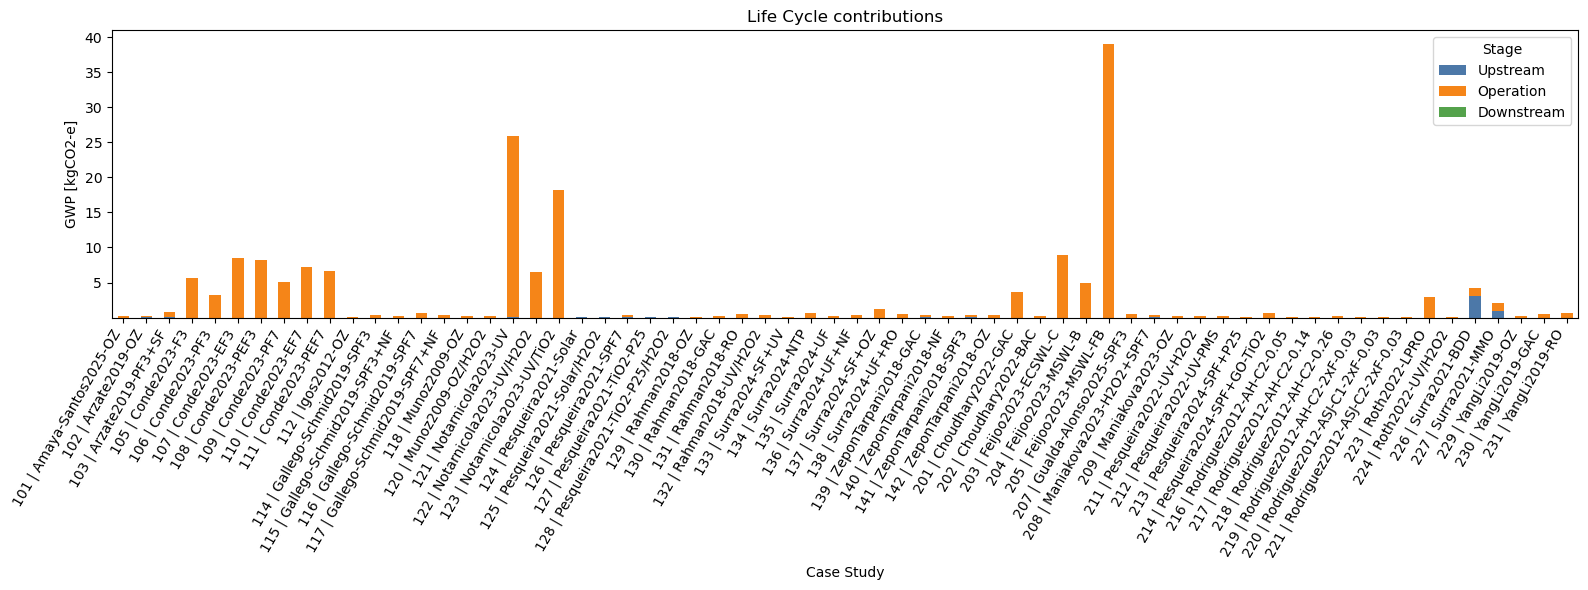

In [9]:
# Plot all GWP values
import pandas as pd
import matplotlib.pyplot as plt

stack_cols = ["Upstream", "Operation", "Downstream"]
gwp_agg = gwp_agg[~gwp_agg.index.isna()]

plot_df = gwp_agg[["case study ID", "UUID"] + stack_cols].copy()
for c in stack_cols:
    plot_df[c] = pd.to_numeric(plot_df[c], errors="coerce")

# Concatenate label: "Case Study ID | UUID"
plot_df["label"] = (
    plot_df["case study ID"].astype(str) + " | " + plot_df["UUID"].astype(str)
)

# Optional: sort by total
plot_df["Total"] = plot_df[stack_cols].sum(axis=1, skipna=True)

ax = plot_df.set_index("label")[stack_cols].plot(
    kind="bar",
    stacked=True,
    figsize=(max(8, len(plot_df) * 0.25), 6),
    color=["#4C78A8", "#F58518", "#54A24B"],
)

plt.xlabel("Case Study")
plt.ylabel("GWP [kgCO2-e]")
plt.title("Life Cycle contributions")
plt.xticks(rotation=60, ha="right")
plt.legend(title="Stage")
plt.tight_layout()
plt.show()

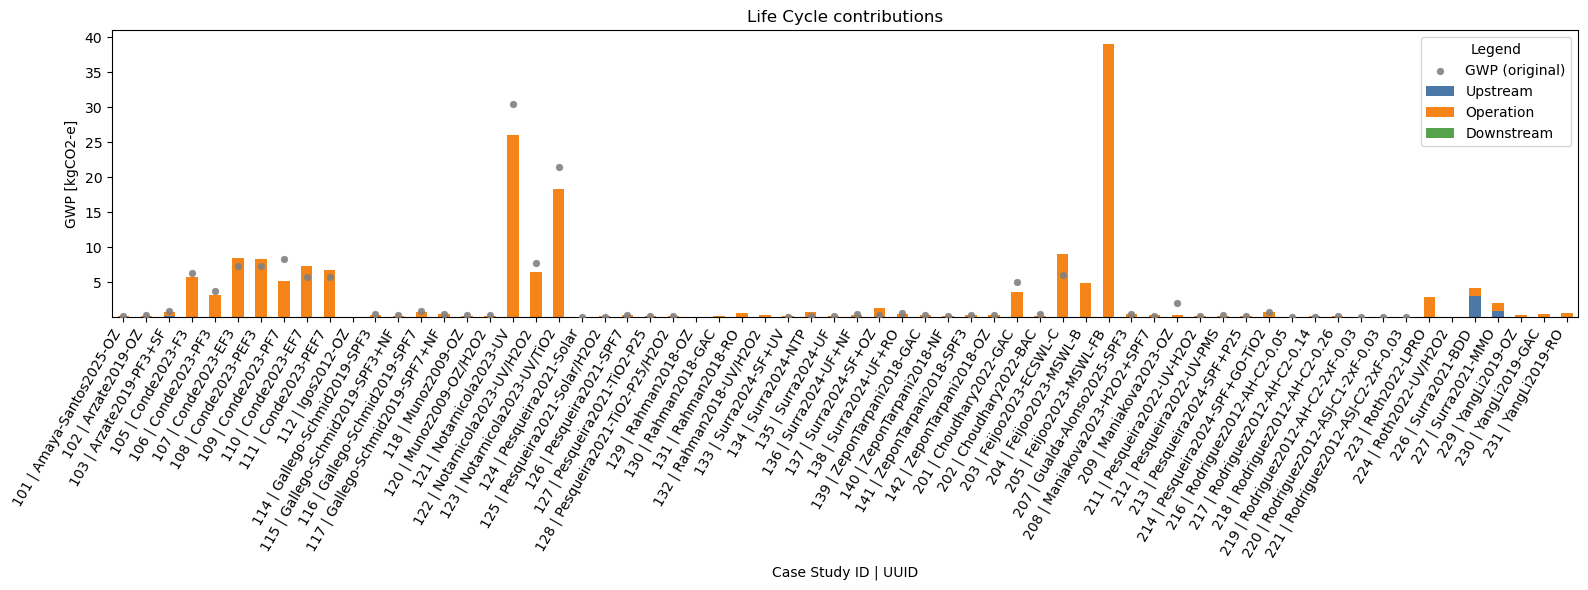

In [10]:
# plot with original GWP/m3 values
import pandas as pd
import matplotlib.pyplot as plt

stack_cols = ["Upstream", "Operation", "Downstream"]
gwp_agg = gwp_agg[~gwp_agg.index.isna()]

plot_df = gwp_agg[["case study ID", "UUID"] + stack_cols].copy()
for c in stack_cols:
    plot_df[c] = pd.to_numeric(plot_df[c], errors="coerce")

# Add GWP/m3 as numeric for overlay (aligns by index)
plot_df["GWP/m3"] = pd.to_numeric(gwp_agg.loc[plot_df.index, "GWP/m3"], errors="coerce")

# Concatenate label: "Case Study ID | UUID"
plot_df["label"] = (
    plot_df["case study ID"].astype(str) + " | " + plot_df["UUID"].astype(str)
)

# Optional: sort by total
plot_df["Total"] = plot_df[stack_cols].sum(axis=1, skipna=True)

ax = plot_df.set_index("label")[stack_cols].plot(
    kind="bar",
    stacked=True,
    figsize=(max(8, len(plot_df) * 0.25), 6),
    color=["#4C78A8", "#F58518", "#54A24B"],
)

# Overlay grey dots for GWP/m3 (only where available)
import numpy as np

x_pos = np.arange(len(plot_df))  # positions match bar categories
y_vals = plot_df["GWP/m3"].to_numpy()
mask = ~np.isnan(y_vals)
ax.scatter(
    x_pos[mask],
    y_vals[mask],
    color="gray",
    edgecolor="gray",
    linewidth=0.3,
    s=24,
    marker="o",
    alpha=0.9,
    zorder=5,
    label="GWP (original)",
)  # <-- added

plt.xlabel("Case Study ID | UUID")
plt.ylabel("GWP [kgCO2-e]")
plt.title("Life Cycle contributions")
plt.xticks(rotation=60, ha="right")

# Show both stacked-stage legend and the dot entry
plt.legend(title="Legend")

plt.tight_layout()
plt.show()

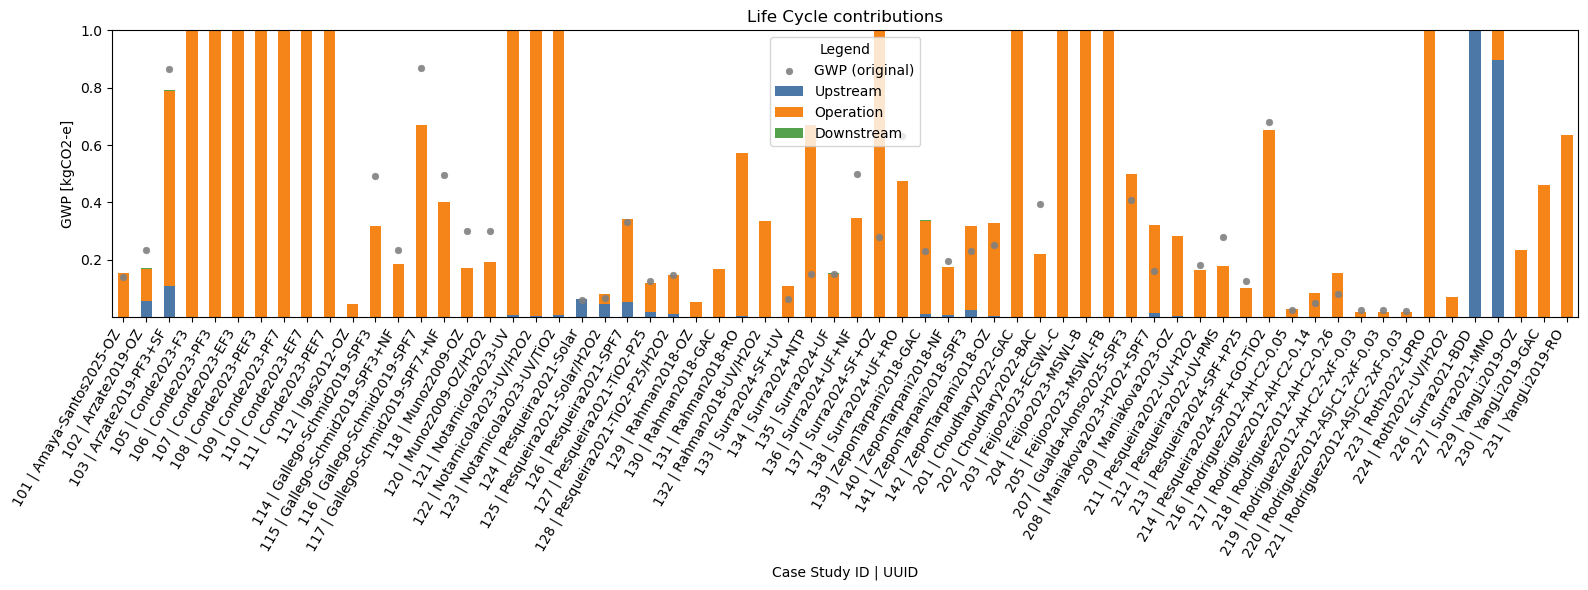

In [152]:
# plot with original GWP/m3 values
import pandas as pd
import matplotlib.pyplot as plt

stack_cols = ["Upstream", "Operation", "Downstream"]
gwp_agg = gwp_agg[~gwp_agg.index.isna()]

plot_df = gwp_agg[["case study ID", "UUID"] + stack_cols].copy()
for c in stack_cols:
    plot_df[c] = pd.to_numeric(plot_df[c], errors="coerce")

# Add GWP/m3 as numeric for overlay (aligns by index)
plot_df["GWP/m3"] = pd.to_numeric(gwp_agg.loc[plot_df.index, "GWP/m3"], errors="coerce")

# Concatenate label: "Case Study ID | UUID"
plot_df["label"] = (
    plot_df["case study ID"].astype(str) + " | " + plot_df["UUID"].astype(str)
)

# Optional: sort by total
plot_df["Total"] = plot_df[stack_cols].sum(axis=1, skipna=True)

ax = plot_df.set_index("label")[stack_cols].plot(
    kind="bar",
    stacked=True,
    figsize=(max(8, len(plot_df) * 0.25), 6),
    color=["#4C78A8", "#F58518", "#54A24B"],
)

# Overlay grey dots for GWP/m3 (only where available)
import numpy as np

x_pos = np.arange(len(plot_df))  # positions match bar categories
y_vals = plot_df["GWP/m3"].to_numpy()
mask = ~np.isnan(y_vals)
ax.scatter(
    x_pos[mask],
    y_vals[mask],
    color="gray",
    edgecolor="gray",
    linewidth=0.3,
    s=24,
    marker="o",
    alpha=0.9,
    zorder=5,
    label="GWP (original)",
)  # <-- added

plt.xlabel("Case Study ID | UUID")
plt.ylabel("GWP [kgCO2-e]")
plt.title("Life Cycle contributions")
plt.xticks(rotation=60, ha="right")

# Limit y-axis to 1.0 as requested
ax.set_ylim(top=1.0)

# Show both stacked-stage legend and the dot entry
plt.legend(title="Legend")

plt.tight_layout()
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\25664386.py:19: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  plot_df["case study ID"] = plot_df["case study ID"].replace({"", "nan", "None", "NA"})
C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\25664386.py:20: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  plot_df["UUID"] = plot_df["UUID"].replace({"", "nan", "None", "NA"})


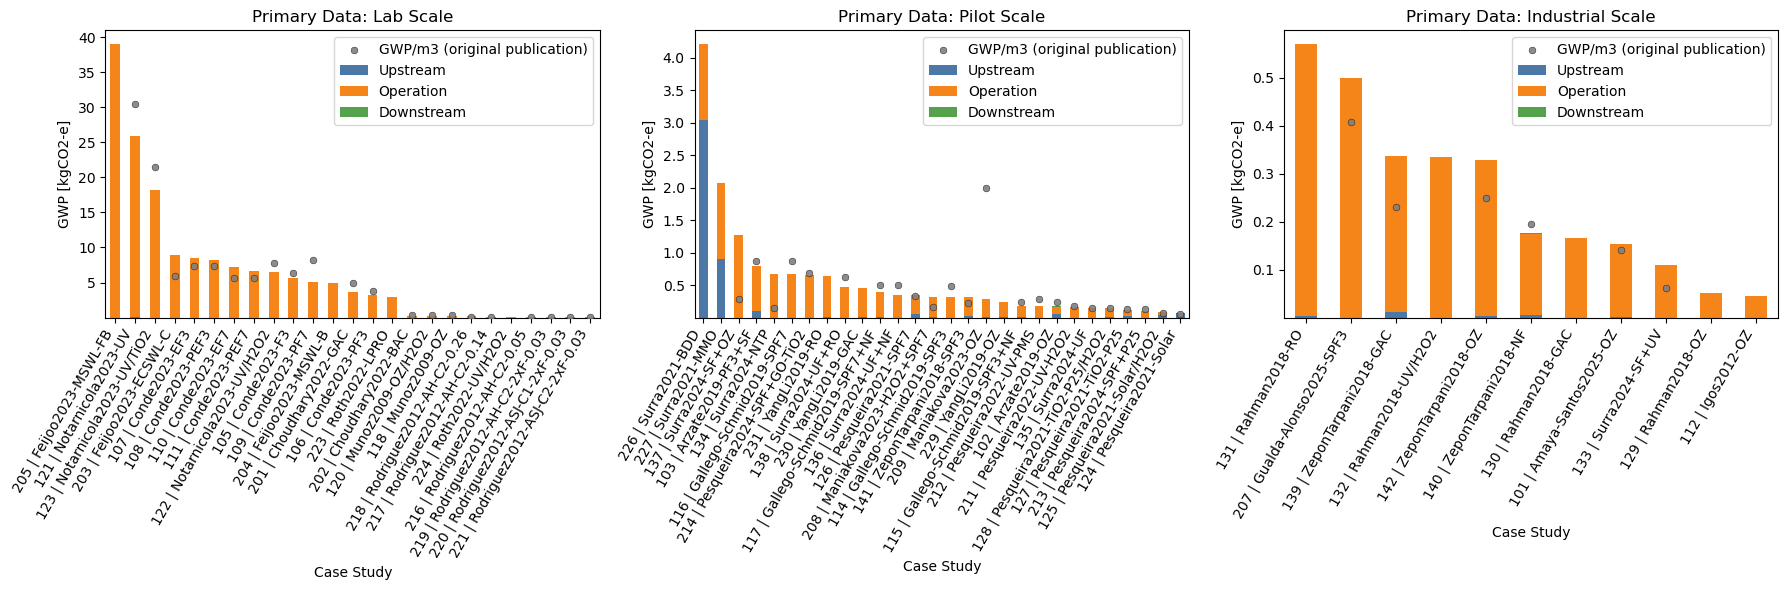

In [149]:
# Plot per Primary Data Group
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

stack_cols = ["Upstream", "Operation", "Downstream"]

# Build and clean
plot_df = gwp_agg[
    ["case study ID", "UUID", "primary data", "GWP/m3"] + stack_cols
].copy()
for c in stack_cols:
    plot_df[c] = pd.to_numeric(plot_df[c], errors="coerce")
plot_df["GWP/m3"] = pd.to_numeric(plot_df["GWP/m3"], errors="coerce")

# Safe, non-empty labels
plot_df["case study ID"] = plot_df["case study ID"].astype(str).str.strip()
plot_df["UUID"] = plot_df["UUID"].astype(str).str.strip()
plot_df["case study ID"] = plot_df["case study ID"].replace({"", "nan", "None", "NA"})
plot_df["UUID"] = plot_df["UUID"].replace({"", "nan", "None", "NA"})
plot_df["label"] = plot_df["case study ID"] + " | " + plot_df["UUID"]

# Drop rows with all NaNs in stack cols
plot_df = plot_df[plot_df[stack_cols].notna().any(axis=1)]

# Normalize primary data values and enforce order
primary_raw = plot_df["primary data"].astype("string").str.strip()
norm_map = {
    "lab scale": "Lab Scale",
    "bench scale": "Lab Scale",  # <- treat as Lab Scale
    "pilot scale": "Pilot Scale",
    "industrial scale": "Industrial Scale",
}
plot_df["primary_norm"] = primary_raw.str.lower().map(norm_map).fillna(primary_raw)
plot_df["primary_norm"] = plot_df["primary_norm"].fillna("Other")
valid = ["Lab Scale", "Pilot Scale", "Industrial Scale"]
plot_df.loc[~plot_df["primary_norm"].isin(valid), "primary_norm"] = "Other"

desired_order = ["Lab Scale", "Pilot Scale", "Industrial Scale", "Other"]
plot_df["primary_norm"] = plot_df["primary_norm"].astype(
    pd.CategoricalDtype(categories=desired_order, ordered=True)
)

# Build groups in enforced order (skip those not present)
present = [c for c in desired_order if c in plot_df["primary_norm"].unique().tolist()]
groups = [(k, plot_df[plot_df["primary_norm"] == k].copy()) for k in present]

# Plot
fig, axes = plt.subplots(1, len(groups), figsize=(6 * len(groups), 6), squeeze=False)
axes = axes.ravel()

for i, (primary_val, subset) in enumerate(groups):
    # Aggregate exact-duplicate labels for stacked bars
    subset_bars = subset.groupby("label", as_index=False)[stack_cols].sum()

    # Sort by total
    subset_bars["Total"] = subset_bars[stack_cols].sum(axis=1, skipna=True)
    subset_bars = subset_bars.sort_values("Total", ascending=False)

    plot_frame = subset_bars.set_index("label")[stack_cols]

    ax = axes[i]
    plot_frame.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=["#4C78A8", "#F58518", "#54A24B"],
    )

    # Force tick labels explicitly
    ax.set_xticks(range(len(plot_frame.index)))
    ax.set_xticklabels(plot_frame.index, rotation=60, ha="right")

    # Grey dots overlay: mean GWP/m3 per label (skip NaN), aligned to bars
    alt_series = subset.groupby("label", dropna=False)["GWP/m3"].mean()
    alt_series = alt_series.reindex(plot_frame.index)  # align to bar order
    y_vals = alt_series.to_numpy()
    x_pos = np.arange(len(plot_frame.index))
    mask = ~np.isnan(y_vals)
    ax.scatter(
        x_pos[mask],
        y_vals[mask],
        color="gray",
        edgecolor="black",
        linewidth=0.3,
        s=24,
        marker="o",
        alpha=0.9,
        zorder=5,
        label="GWP/m3 (original publication)",
    )
    ax.set_xlabel("Case Study")
    ax.set_ylabel("GWP [kgCO2-e]")
    ax.set_title(f"Primary Data: {primary_val}")
    ax.legend()

plt.tight_layout()
plt.show()

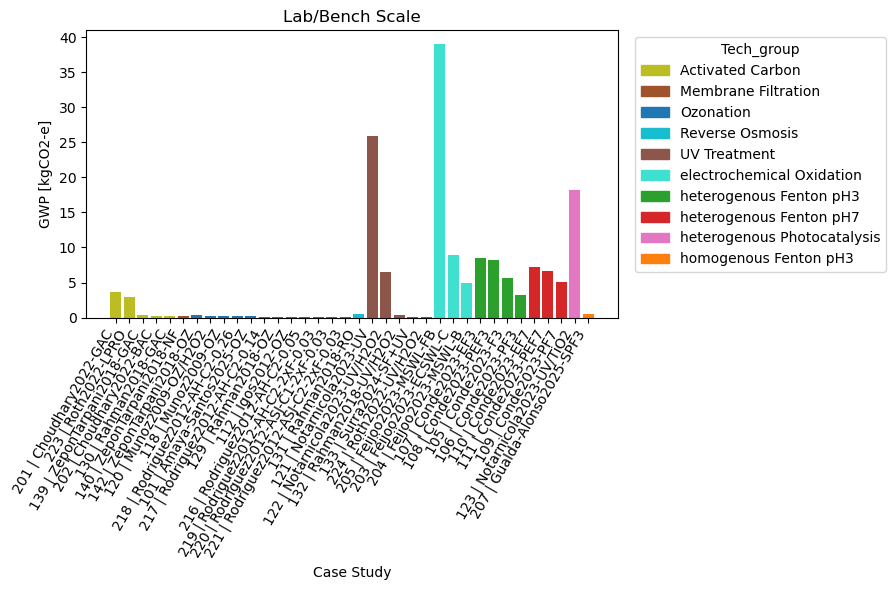

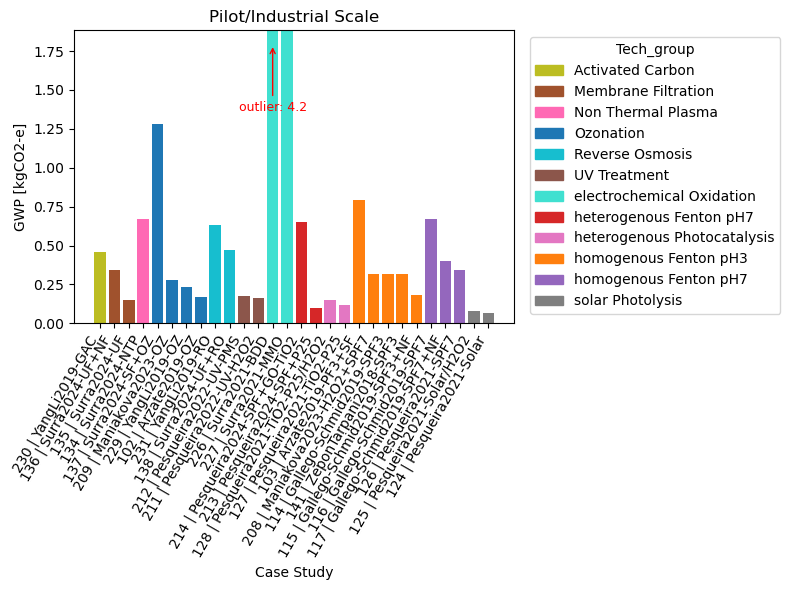

In [ ]:
# plots per technology group
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import cm

# Base data
plot_df = gwp_agg[
    ["case study ID", "UUID", "Tech_group", "Total", "primary data"]
].copy()
plot_df["Total"] = pd.to_numeric(plot_df["Total"], errors="coerce")
plot_df = plot_df.dropna(subset=["Total"])

# Labels
plot_df["label"] = (
    plot_df["case study ID"].astype(str).str.strip()
    + " | "
    + plot_df["UUID"].astype(str).str.strip()
)

# Assign a specific color for each Tech_group, ensuring unique color per group

tech_group_palette = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8C564B",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow/green
    "#17becf",  # cyan
    "#FF69B4",  # hot pink
    "#A0522D",  # sienna
    "#40E0D0",  # turquoise
    "#FFD700",  # gold
    "#DC143C",  # crimson
    "#00CED1",  # dark turquoise
    "#C0C0C0",  # silver
    "#00008B",  # dark blue
    "#808000",  # olive
    "#C71585",  # medium violet red
    "#4682B4",  # steel blue
    "#008080",  # teal
    "#483D8B",  # dark slate blue
    "#ffa500",  # another orange in case
]

all_groups = list(plot_df["Tech_group"].dropna().unique())

# If number of groups is greater than palette, create additional colors
if len(all_groups) > len(tech_group_palette):
    import matplotlib

    cmap = matplotlib.cm.get_cmap("hsv", len(all_groups))
    extended_palette = [
        matplotlib.colors.to_hex(cmap(i)) for i in range(len(all_groups))
    ]
else:
    extended_palette = tech_group_palette

color_map = dict(zip(all_groups, extended_palette[: len(all_groups)]))


# Map each row into its plot group ("Lab/Bench Scale" vs "Pilot/Industrial Scale")
def scale_group(row):
    pd_str = str(row.get("primary data", "")).strip().lower()
    tg_str = str(row.get("Tech_group", "")).strip().lower()
    # Label as Lab/Bench if either column matches; else Pilot/Industrial
    if pd_str == "lab scale" or tg_str == "bench scale":
        return "Lab/Bench Scale"
    elif pd_str == "pilot scale" or tg_str == "industrial scale":
        return "Pilot/Industrial Scale"
    else:
        # If neither explicitly matches (for robustness), assign "Lab/Bench Scale" if "bench" in group name
        if "bench" in tg_str:
            return "Lab/Bench Scale"
        elif "industrial" in tg_str or "pilot" in pd_str:
            return "Pilot/Industrial Scale"
        else:
            # Default to "Lab/Bench Scale"
            return "Lab/Bench Scale"


plot_df["plot_group"] = plot_df.apply(scale_group, axis=1)

# Plot all Lab/Bench Scale, then all Pilot/Industrial Scale
for plot_group in ["Lab/Bench Scale", "Pilot/Industrial Scale"]:
    group_df = plot_df[plot_df["plot_group"] == plot_group].copy()
    if group_df.empty:
        print(f"No data to plot for {plot_group}")
        continue

    # Reorder rows by Tech_group (alphabetical), within each by Total desc
    ordered_frames = []
    for g in sorted(group_df["Tech_group"].dropna().unique()):
        df_g = group_df[group_df["Tech_group"] == g].copy()
        if df_g.empty:
            continue
        df_g = df_g.sort_values("Total", ascending=False)
        ordered_frames.append(df_g)
    if not ordered_frames:
        print(f"No data to plot for {plot_group}")
        continue
    plot_df_ord = pd.concat(ordered_frames, ignore_index=True)
    bar_colors = plot_df_ord["Tech_group"].map(color_map)

    plt.figure(figsize=(max(8, len(plot_df_ord) * 0.25), 6))
    plt.bar(plot_df_ord["label"], plot_df_ord["Total"], color=bar_colors)
    plt.xlabel("Case Study")
    plt.ylabel("GWP [kgCO2-e]")
    plt.title(plot_group)

    # Legend: show Tech_group colors in plot order (remove duplicates, preserve order)
    legend_groups = list(dict.fromkeys(plot_df_ord["Tech_group"]))
    handles = [mpatches.Patch(color=color_map[g], label=g) for g in legend_groups]
    plt.legend(
        handles=handles, title="Tech_group", bbox_to_anchor=(1.02, 1), loc="upper left"
    )

    plt.xticks(rotation=60, ha="right")

    # Truncate y-axis if strong outlier
    y = plot_df_ord["Total"].values
    if len(y) > 2:
        y_sorted = np.sort(y)
        y_max = y_sorted[-1]
        y_second_max = y_sorted[-2] if len(y_sorted) > 1 else y_max
        y95 = np.percentile(y, 95)
        y_lim = min(y95, y_second_max)
        if y_max > 2 * y_lim:
            plt.ylim(top=y_lim * 1.05)
            outlier_index = np.argmax(y)
            outlier_value = y_max
            plt.annotate(
                f"outlier: {outlier_value:.2g}",
                xy=(outlier_index, y_lim),
                xytext=(outlier_index, y_lim * 0.75),
                ha="center",
                va="bottom",
                arrowprops=dict(arrowstyle="->", color="red"),
                fontsize=9,
                color="red",
            )
    plt.tight_layout()
    plt.show()

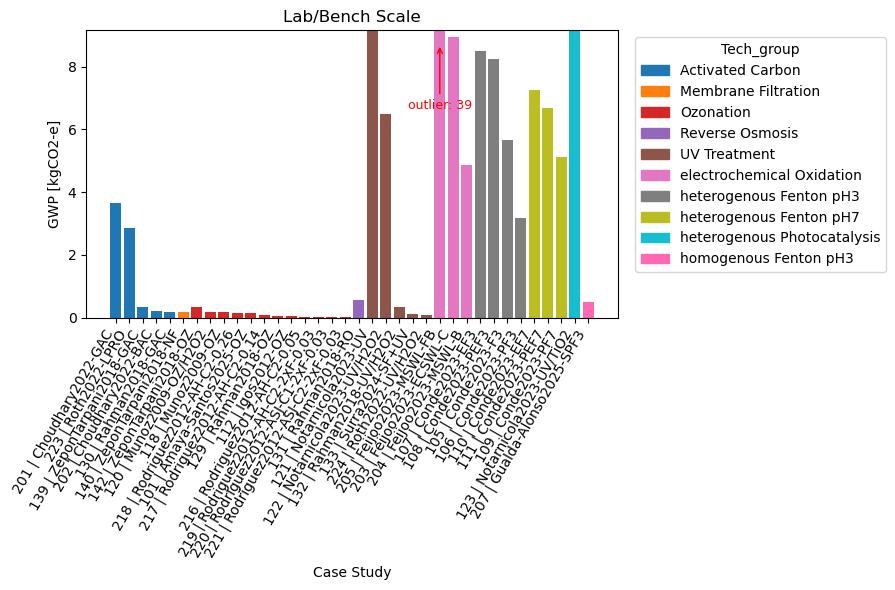

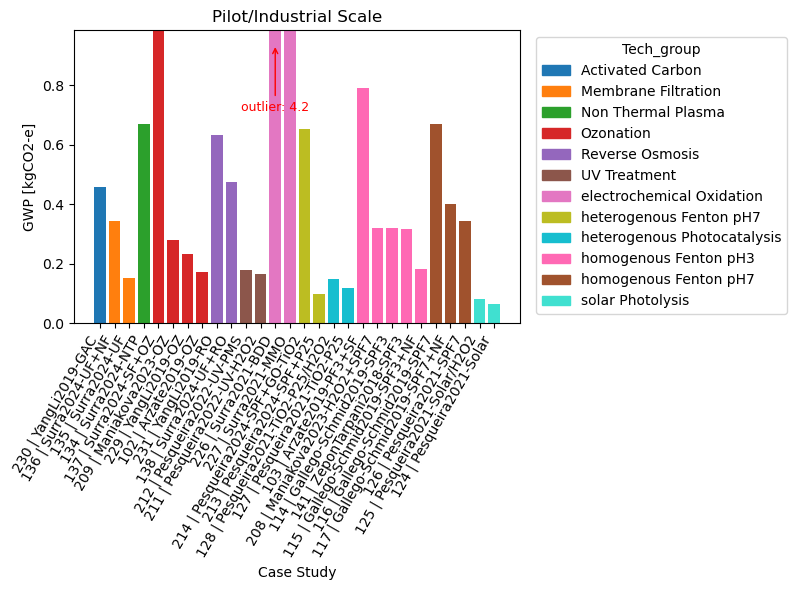

In [ ]:
# Simple, reliable bar plots per scale with correct x labels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Base data
plot_df = gwp_agg[
    ["case study ID", "UUID", "Tech_group", "Total", "primary data"]
].copy()
plot_df["Total"] = pd.to_numeric(plot_df["Total"], errors="coerce")
plot_df = plot_df.dropna(subset=["Total"])

# Labels (unique per row)
plot_df["label"] = (
    plot_df["case study ID"].astype(str).str.strip()
    + " | "
    + plot_df["UUID"].astype(str).str.strip()
)

# Stable color mapping per Tech_group
all_groups = sorted(plot_df["Tech_group"].dropna().unique())
palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8C564B",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
    "#FF69B4",
    "#A0522D",
    "#40E0D0",
    "#FFD700",
    "#DC143C",
    "#00CED1",
    "#C0C0C0",
    "#00008B",
    "#808000",
    "#C71585",
    "#4682B4",
    "#008080",
    "#483D8B",
    "#ffa500",
]
if len(all_groups) > len(palette):
    import matplotlib

    cmap = matplotlib.cm.get_cmap("hsv", len(all_groups))
    palette = [matplotlib.colors.to_hex(cmap(i)) for i in range(len(all_groups))]

color_map = dict(zip(all_groups, palette[: len(all_groups)]))


def scale_group(row):
    pd_str = str(row.get("primary data", "")).strip().lower()
    tg_str = str(row.get("Tech_group", "")).strip().lower()
    if pd_str == "lab scale" or tg_str == "bench scale":
        return "Lab/Bench Scale"
    if pd_str == "pilot scale" or tg_str == "industrial scale":
        return "Pilot/Industrial Scale"
    if "bench" in tg_str:
        return "Lab/Bench Scale"
    if "industrial" in tg_str or "pilot" in pd_str:
        return "Pilot/Industrial Scale"
    return "Lab/Bench Scale"


plot_df["plot_group"] = plot_df.apply(scale_group, axis=1)

for plot_group in ["Lab/Bench Scale", "Pilot/Industrial Scale"]:
    df = plot_df[plot_df["plot_group"] == plot_group].copy()
    if df.empty:
        print(f"No data to plot for {plot_group}")
        continue

    # Order by Tech_group (alphabetical), then Total descending
    df["Tech_group"] = pd.Categorical(
        df["Tech_group"], categories=all_groups, ordered=True
    )
    df = df.sort_values(["Tech_group", "Total"], ascending=[True, False]).reset_index(
        drop=True
    )

    labels = df["label"].tolist()
    values = df["Total"].to_numpy()
    bar_colors = df["Tech_group"].map(color_map).tolist()

    x = np.arange(len(df))  # numeric positions

    plt.figure(figsize=(max(8, len(df) * 0.25), 6))
    plt.bar(x, values, color=bar_colors)
    plt.xticks(x, labels, rotation=60, ha="right")  # labels align with bars
    plt.xlabel("Case Study")
    plt.ylabel("GWP [kgCO2-e]")
    plt.title(plot_group)

    # Legend (unique Tech_groups in plot order)
    legend_groups = list(dict.fromkeys(df["Tech_group"]))
    handles = [mpatches.Patch(color=color_map[g], label=g) for g in legend_groups]
    plt.legend(
        handles=handles, title="Tech_group", bbox_to_anchor=(1.02, 1), loc="upper left"
    )

    # Optional: truncate y-axis if a strong outlier skews visibility
    if len(values) > 2:
        y_sorted = np.sort(values)
        y_max = y_sorted[-1]
        y_second_max = y_sorted[-2] if len(y_sorted) > 1 else y_max
        y90 = np.percentile(values, 90)
        y_lim = min(y90, y_second_max)
        if y_max > 2 * y_lim:
            plt.ylim(top=y_lim * 1.05)
            oi = int(np.argmax(values))
            plt.annotate(
                f"outlier: {y_max:.2g}",
                xy=(oi, y_lim),
                xytext=(oi, y_lim * 0.75),
                ha="center",
                va="bottom",
                arrowprops=dict(arrowstyle="->", color="red"),
                fontsize=9,
                color="red",
            )

    plt.tight_layout()
    plt.show()

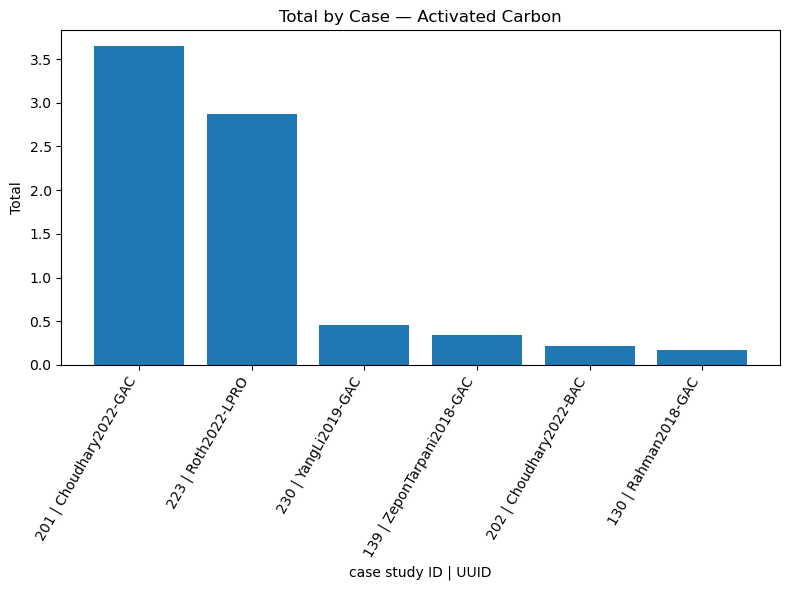

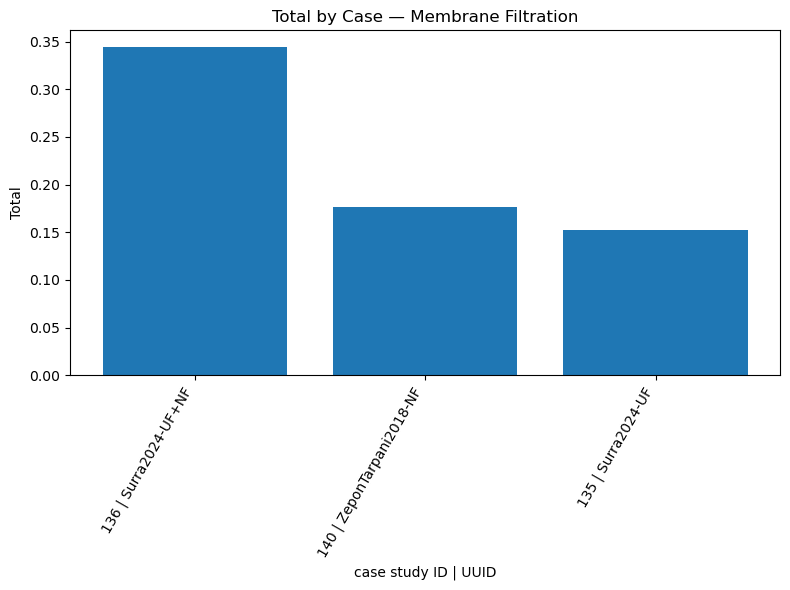

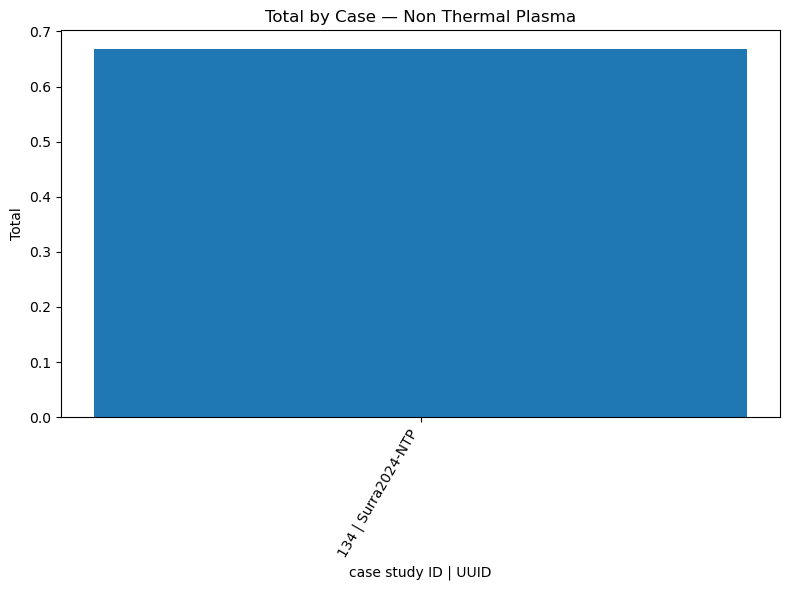

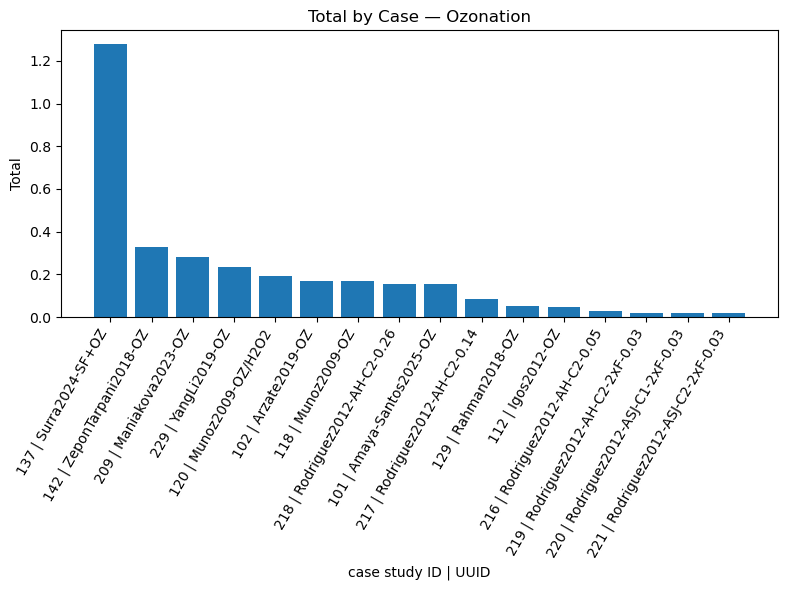

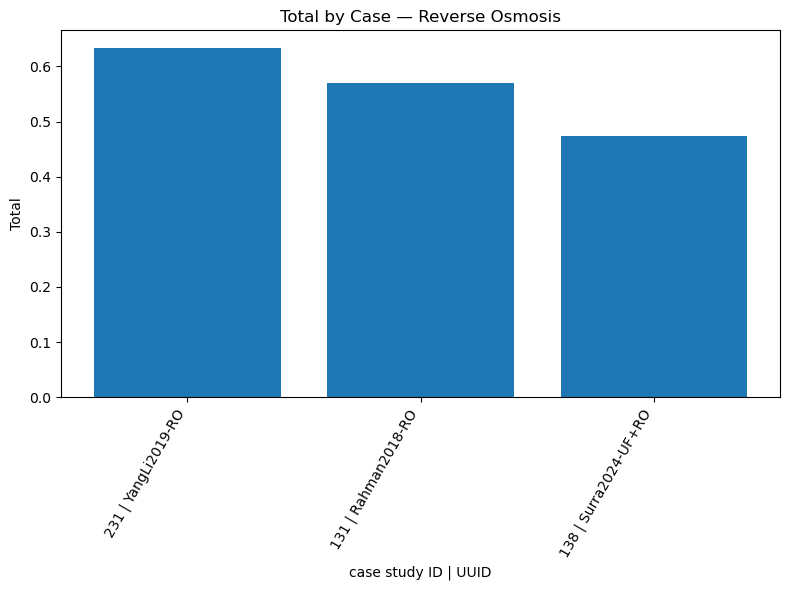

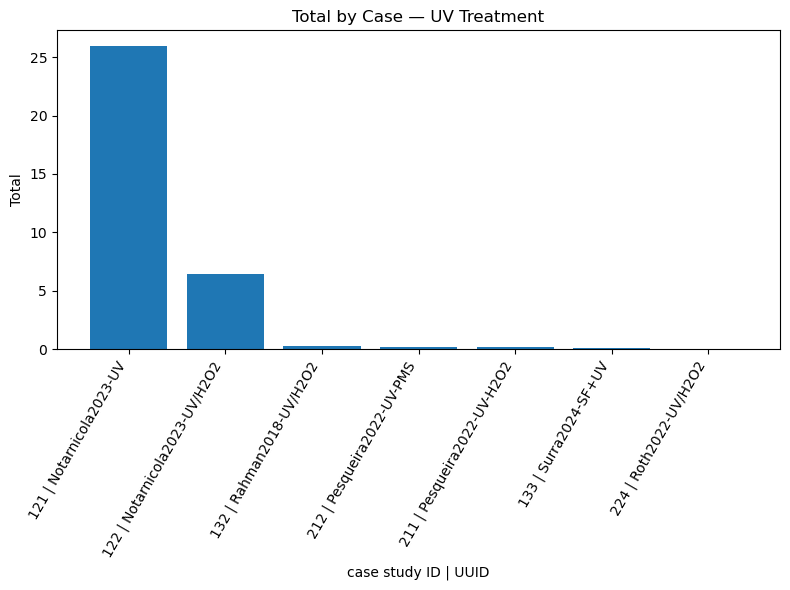

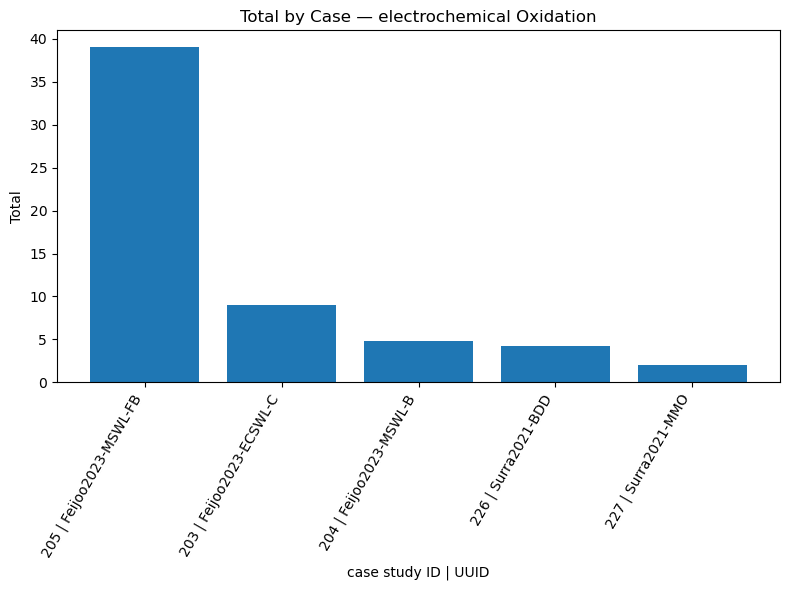

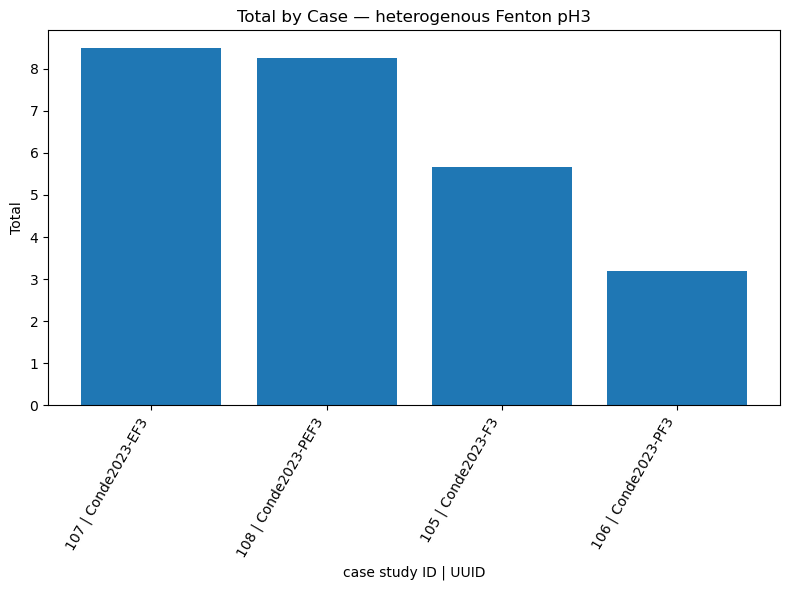

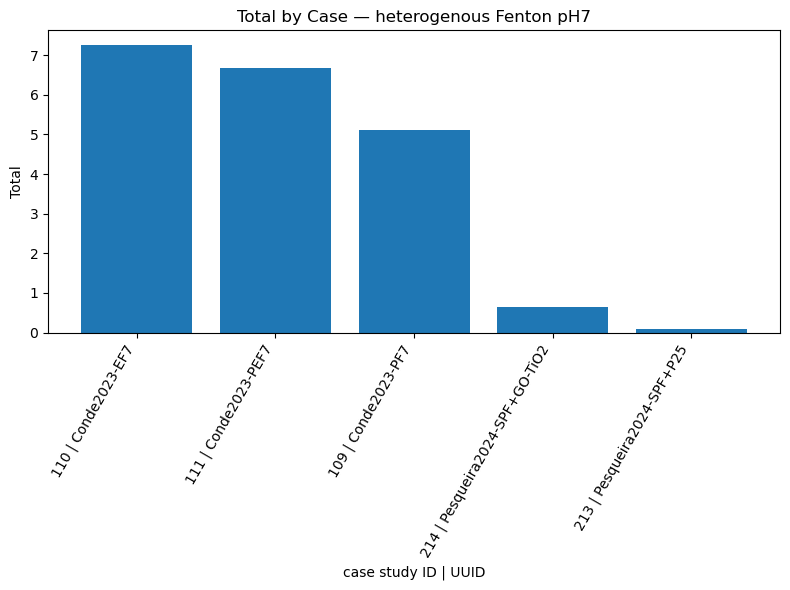

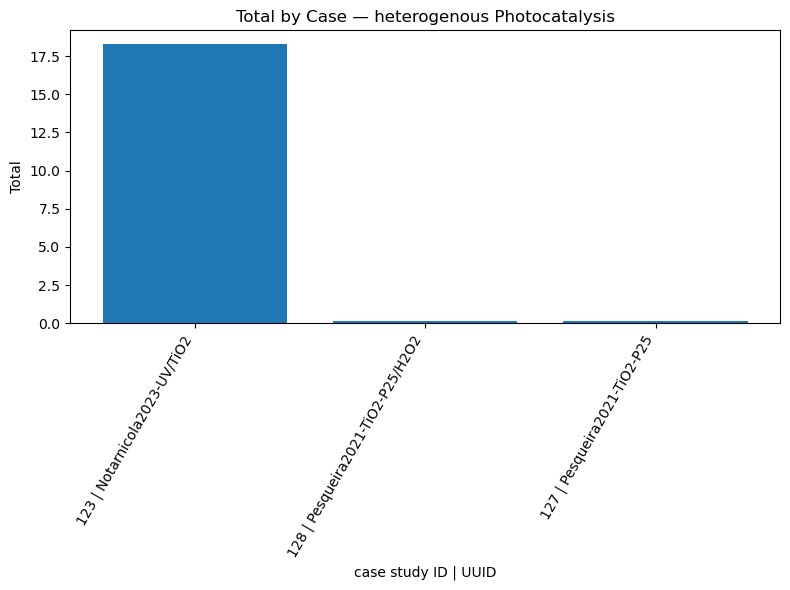

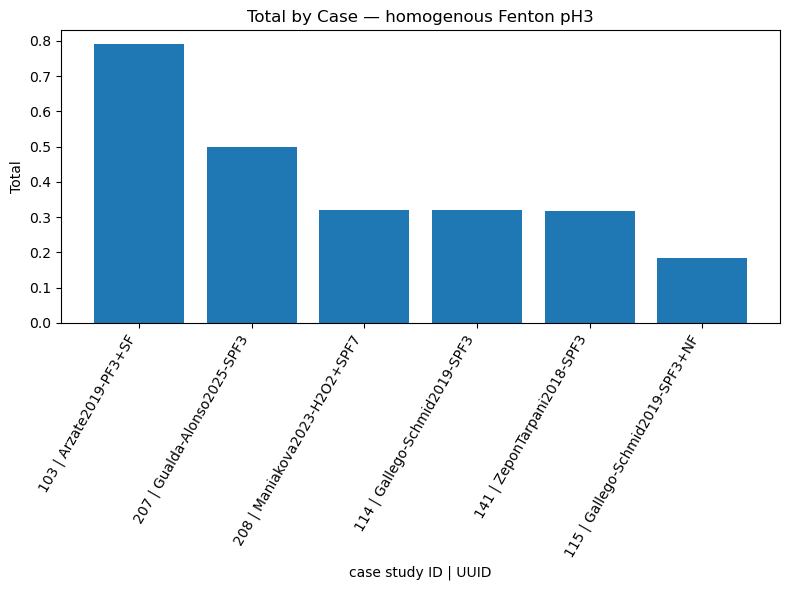

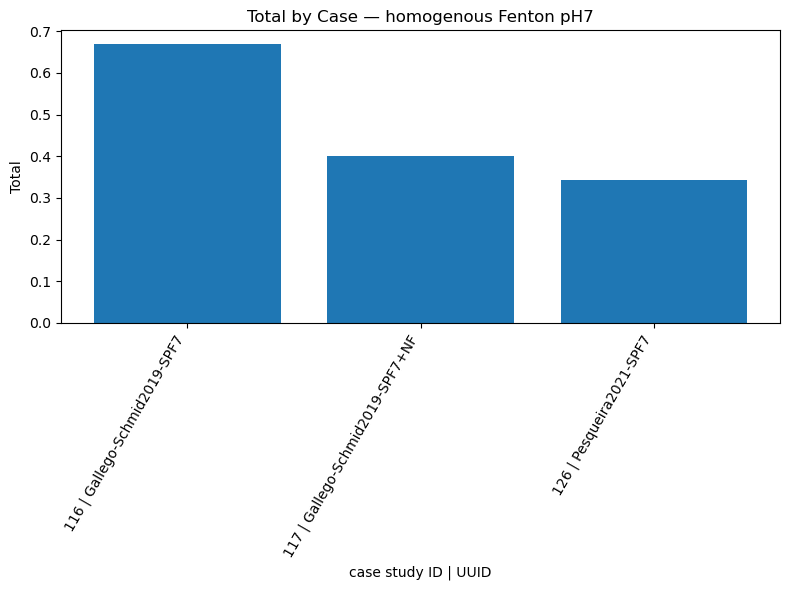

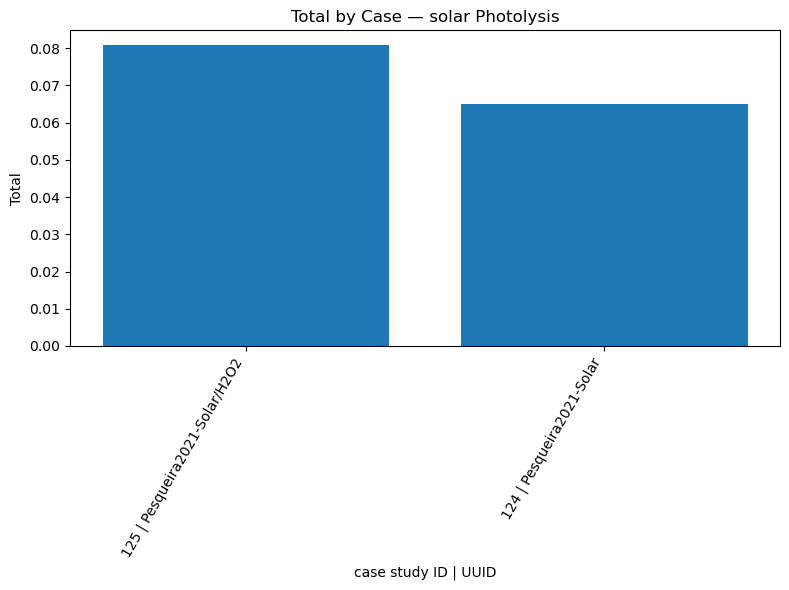

In [ ]:
# plot per technology
import pandas as pd


import matplotlib.pyplot as plt


# Minimal prep


df = gwp_agg[["case study ID", "UUID", "Tech_group", "Total"]].copy()


df["Total"] = pd.to_numeric(df["Total"], errors="coerce")


df = df.dropna(subset=["Total"])


# Label shown on x-axis


df["label"] = (
    df["case study ID"].astype(str).str.strip()
    + " | "
    + df["UUID"].astype(str).str.strip()
)


# One figure per Tech_group


for tech, sub in df.groupby("Tech_group", dropna=False):

    if sub.empty:
        continue

    sub = sub.sort_values("Total", ascending=False)

    plt.figure(figsize=(max(8, len(sub) * 0.25), 6))

    plt.bar(sub["label"], sub["Total"])

    plt.title(f"Total by Case — {tech}")

    plt.xlabel("case study ID | UUID")
    plt.ylabel("Total")

    plt.xticks(rotation=60, ha="right")

    plt.tight_layout()

    plt.show()

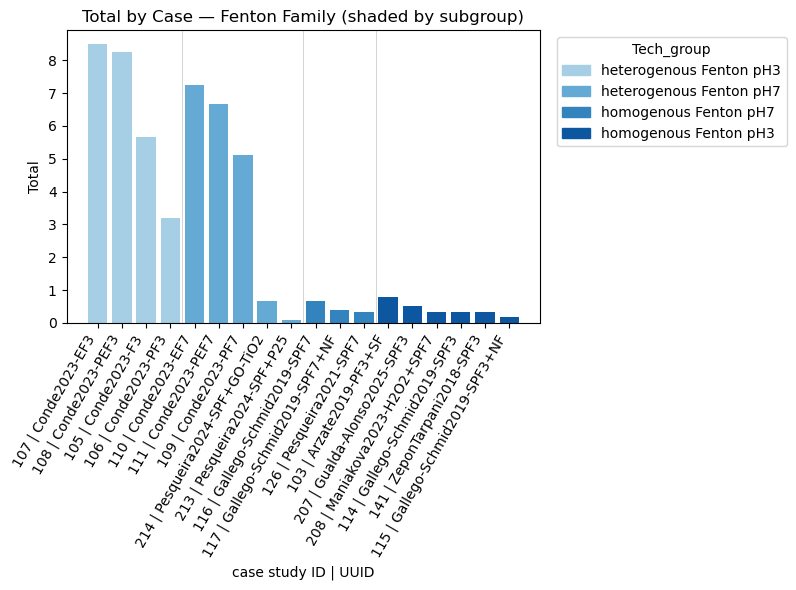

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import cm

# Fenton groups (adjust names if needed)
fenton_groups = [
    "heterogenous Fenton pH3",
    "heterogenous Fenton pH7",
    "homogenous Fenton pH7",
    "homogenous Fenton pH3",
]

# Prepare data
df = gwp_agg[["case study ID", "UUID", "Tech_group", "Total"]].copy()
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")
df = df[df["Tech_group"].isin(fenton_groups)].dropna(subset=["Total"])

if df.empty:
    print("No Fenton rows found.")
else:
    # Avoid MultiIndex surprises
    df = df.reset_index(drop=True).copy()

    df["label"] = (
        df["case study ID"].astype(str).str.strip()
        + " | "
        + df["UUID"].astype(str).str.strip()
    )
    # Order by Tech_group (given order), then Total desc
    df["Tech_group"] = pd.Categorical(
        df["Tech_group"], categories=fenton_groups, ordered=True
    )
    df = df.sort_values(["Tech_group", "Total"], ascending=[True, False]).reset_index(
        drop=True
    )

    # Assign distinct shades per Fenton subgroup (same base palette, different shades)
    present = df["Tech_group"].cat.categories[
        df["Tech_group"].value_counts().sort_index() > 0
    ]
    shade_positions = np.linspace(0.35, 0.85, num=len(present))
    shade_map = {g: cm.Blues(s) for g, s in zip(present, shade_positions)}

    # Robust mapping (no MultiIndex ops)
    colors = df["Tech_group"].astype(str).map(shade_map)

    # Plot
    plt.figure(figsize=(max(8, len(df) * 0.25), 6))
    plt.bar(df["label"], df["Total"], color=colors)
    plt.title("Total by Case — Fenton Family (shaded by subgroup)")
    plt.xlabel("case study ID | UUID")
    plt.ylabel("Total")
    plt.xticks(rotation=60, ha="right")

    # Group separators
    changes = df["Tech_group"].ne(df["Tech_group"].shift()).to_numpy().nonzero()[0]
    for idx in changes[1:]:
        plt.axvline(idx - 0.5, color="gray", linewidth=0.6, alpha=0.4)

    # Legend with shades
    handles = [mpatches.Patch(color=shade_map[g], label=g) for g in present]
    plt.legend(
        handles=handles, title="Tech_group", bbox_to_anchor=(1.02, 1), loc="upper left"
    )

    plt.tight_layout()
    plt.show()

# Box Plots and statistics

In [ ]:
rest_stats.to_excel(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\Calculation Results\pilotscale_stats.xlsx"
)
lab_stats.to_excel(
    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\Calculation Results\labscale_stats.xlsx"
)

C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\3689173256.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box1 = axes[0].boxplot(data1, labels=groups1, patch_artist=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\3689173256.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box2 = axes[1].boxplot(data2, labels=groups2, patch_artist=True)


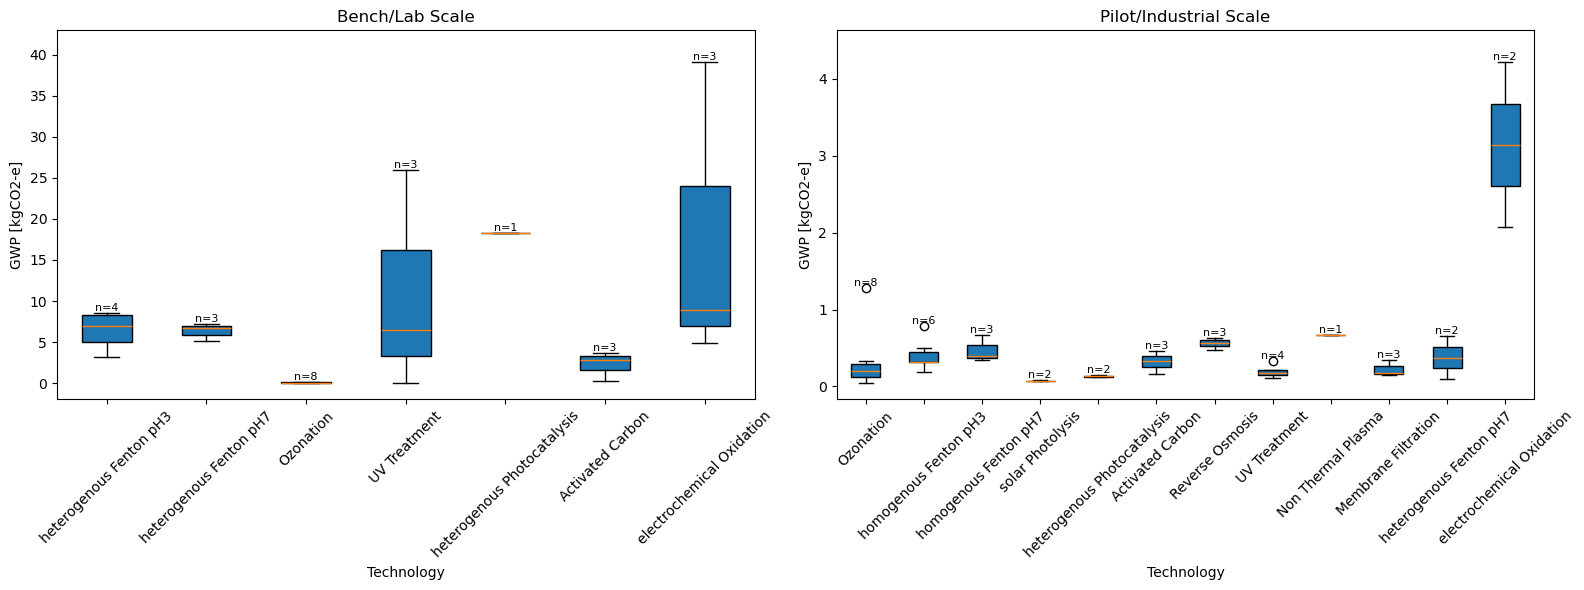

In [30]:
# boxplot with values from column Total
df = gwp_agg[["case study ID", "UUID", "Tech_group", "Total", "primary data"]].copy()
import matplotlib.pyplot as plt

# Define groups for each scale
lab_bench_scales = ["lab scale", "bench scale"]
pilot_industrial_scales = ["Pilot scale", "industrial scale"]

# Prepare data
df1 = df[df["primary data"].str.lower().isin([s.lower() for s in lab_bench_scales])]
groups1 = df1["Tech_group"].dropna().unique()
data1 = [df1[df1["Tech_group"] == g]["Total"].dropna() for g in groups1]

df2 = df[
    df["primary data"].str.lower().isin([s.lower() for s in pilot_industrial_scales])
]
groups2 = df2["Tech_group"].dropna().unique()
data2 = [df2[df2["Tech_group"] == g]["Total"].dropna() for g in groups2]

# Create a figure with two subplots (separate y-axis scaling)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Boxplot 1: Bench/Lab scale
box1 = axes[0].boxplot(data1, labels=groups1, patch_artist=True)
axes[0].set_xlabel("Technology")
axes[0].set_ylabel("GWP [kgCO2-e]")
axes[0].set_title("Bench/Lab Scale")
axes[0].tick_params(axis="x", rotation=45)

# Set individual y-axis limits for Bench/Lab scale for better display
if len(data1) > 0 and any(len(d) > 0 for d in data1):
    y1_min = min([min(d) for d in data1 if len(d) > 0])
    y1_max = max([max(d) for d in data1 if len(d) > 0])
    delta1 = y1_max - y1_min
    axes[0].set_ylim(y1_min - 0.05 * delta1, y1_max + 0.10 * delta1)

# Add number of case studies at the top of each box for Bench/Lab scale
for i, g in enumerate(groups1):
    n = len(df1[df1["Tech_group"] == g]["Total"].dropna())
    y_max = max(data1[i]) if len(data1[i]) > 0 else 0
    axes[0].text(
        i + 1, y_max, f"n={n}", ha="center", va="bottom", fontsize=8, fontweight="light"
    )

# Boxplot 2: Pilot/Industrial scale
box2 = axes[1].boxplot(data2, labels=groups2, patch_artist=True)
axes[1].set_xlabel("Technology")
axes[1].set_ylabel("GWP [kgCO2-e]")
axes[1].set_title("Pilot/Industrial Scale")
axes[1].tick_params(axis="x", rotation=45)

# Set individual y-axis limits for Pilot/Industrial scale for better display
if len(data2) > 0 and any(len(d) > 0 for d in data2):
    y2_min = min([min(d) for d in data2 if len(d) > 0])
    y2_max = max([max(d) for d in data2 if len(d) > 0])
    delta2 = y2_max - y2_min
    axes[1].set_ylim(y2_min - 0.05 * delta2, y2_max + 0.10 * delta2)

# Add number of case studies at the top of each box for Pilot/Industrial scale
for i, g in enumerate(groups2):
    n = len(df2[df2["Tech_group"] == g]["Total"].dropna())
    y_max = max(data2[i]) if len(data2[i]) > 0 else 0
    axes[1].text(
        i + 1, y_max, f"n={n}", ha="center", va="bottom", fontsize=8, fontweight="light"
    )

plt.tight_layout()
plt.show()

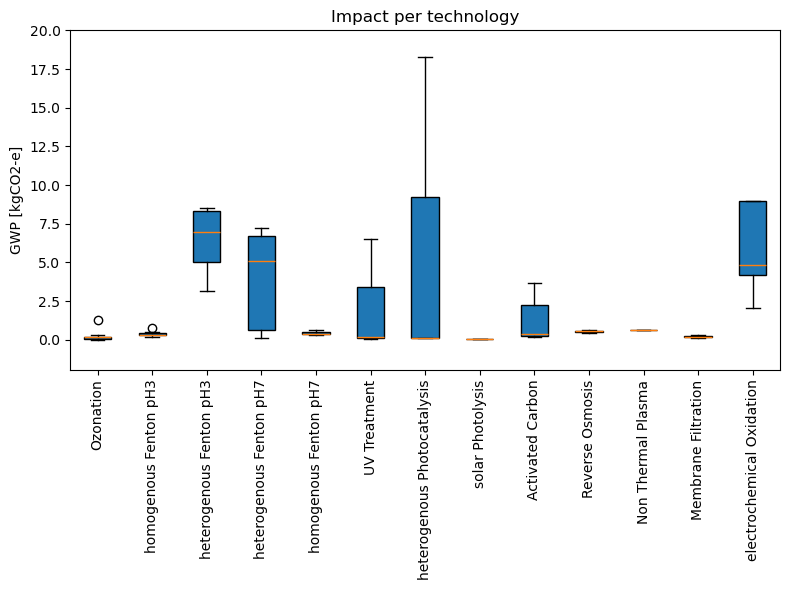

In [ ]:
# boxplot with values from column Total (single graph, no scale grouping)
df = gwp_agg[["case study ID", "UUID", "Tech_group", "Total", "primary data"]].copy()
import matplotlib.pyplot as plt
import numpy as np

# Prepare data - all scales together
groups = df["Tech_group"].dropna().unique()
data = [df[df["Tech_group"] == g]["Total"].dropna() for g in groups]

# Create a single figure
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Create boxplot
box = ax.boxplot(data, tick_labels=groups, patch_artist=True)
ax.set_ylabel("GWP [kgCO2-e]")
ax.set_title("Boxplot by Tech_group")
ax.tick_params(axis="x", rotation=90)

# Set y-axis limits for better display
if len(data) > 0 and any(len(d) > 0 for d in data):
    y_min = min([min(d) for d in data if len(d) > 0])
    y_max = max([max(d) for d in data if len(d) > 0])
    delta = y_max - y_min
    ax.set_ylim(y_min - 0.05 * delta, y_max + 0.10 * delta)

# Instead of displaying n and mean above the boxes, create a small table below x-axis with those values

# Prepare the table data (as strings)
import pandas as pd

stats_table = []
for g in groups:
    subset = df[df["Tech_group"] == g]["Total"].dropna()
    n = len(subset)
    mean_val = np.mean(subset) if n > 0 else float("nan")
    std_val = np.std(subset, ddof=1) if n > 1 else float("nan")
    median_val = np.median(subset) if n > 0 else float("nan")
    min_val = np.min(subset) if n > 0 else float("nan")
    max_val = np.max(subset) if n > 0 else float("nan")
    q25 = np.percentile(subset, 25) if n > 0 else float("nan")
    q75 = np.percentile(subset, 75) if n > 0 else float("nan")
    stats_table.append(
        {
            "Tech_group": g,
            "n": f"{n}",
            "mean": f"{mean_val:.2f}" if n > 0 else "-",
            "std": f"{std_val:.2f}" if n > 1 else "-",
            "median": f"{median_val:.2f}" if n > 0 else "-",
            "min": f"{min_val:.2f}" if n > 0 else "-",
            "25%": f"{q25:.2f}" if n > 0 else "-",
            "75%": f"{q75:.2f}" if n > 0 else "-",
            "max": f"{max_val:.2f}" if n > 0 else "-",
        }
    )

table_df = pd.DataFrame(stats_table)


# Save the stats table as an Excel file
# table_df.to_excel(
#    r"C:\Users\Asus\OneDrive - Universidade de Santiago de Compostela\07_Papers\Harmonization study\tech_group_boxplot_stats.xlsx",
#    index=False,
# )

# print("Stats table saved as 'tech_group_boxplot_stats.xlsx'")
# print(table_df)


# Place the table above the plot, below title, using fig.text
ax.set_title("Impact per technology")  # extra space for table
plt.ylim(top=20)
plt.tight_layout()
plt.show()

### Scatter Plot to correlate with Start Concentration

C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\2041683951.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


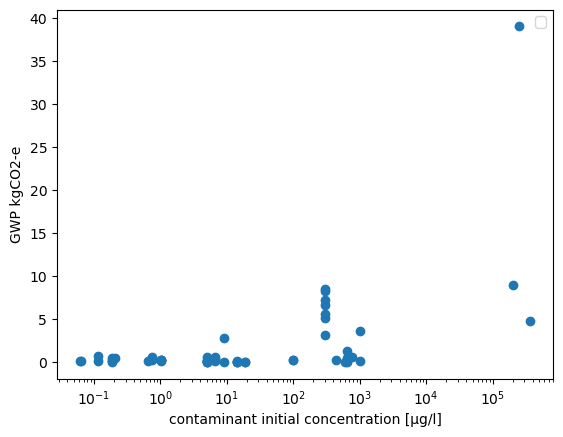

In [ ]:
# Plot Results versus start concentration


# Prepare the data
x_axis = pd.to_numeric(gwp_agg["CBZ start [µg/l]"], errors="coerce")
y_axis = gwp_agg["Total"]

# Remove NaNs and infinities
mask = (~x_axis.isna()) & (~y_axis.isna()) & np.isfinite(x_axis) & np.isfinite(y_axis)
x_clean = x_axis[mask]
y_clean = y_axis[mask]


# Plot scatter & regression
plt.scatter(x_axis, y_axis, color="C0")
plt.xlabel("contaminant initial concentration [µg/l]")
plt.ylabel("GWP kgCO2-e")
plt.xscale("log")
plt.legend()
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_27792\2327859636.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


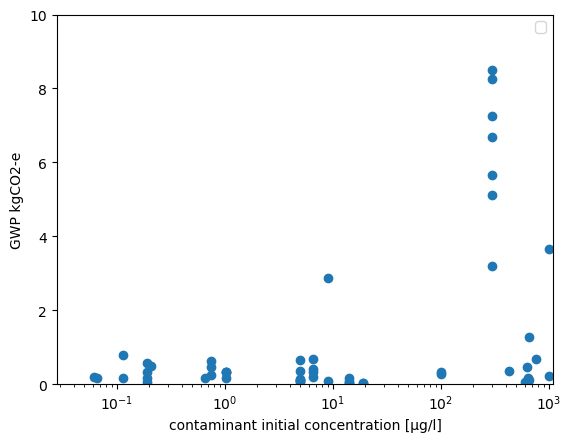

In [ ]:
# Plot Results versus start concentration


# Prepare the data
x_axis = pd.to_numeric(gwp_agg["CBZ start [µg/l]"], errors="coerce")
y_axis = gwp_agg["Total"]

# Remove NaNs and infinities
mask = (~x_axis.isna()) & (~y_axis.isna()) & np.isfinite(x_axis) & np.isfinite(y_axis)
x_clean = x_axis[mask]
y_clean = y_axis[mask]


# Plot scatter & regression
plt.scatter(x_axis, y_axis, color="C0")
plt.xlabel("contaminant initial concentration [µg/l]")
plt.ylabel("GWP kgCO2-e")
plt.xscale("log")
plt.xlim(right=1.1e3)
plt.ylim(bottom=0, top=10)
plt.legend()
plt.show()